## Spread Seasonality Model

###### *"Premature optimization is the root of all evil.." -Donald Knuth*

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd  #Version 0.24.2
import numpy as np
import math
import datetime
import sqlite3
import time
import re

In [2]:
mstart = time.time()

In [3]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

### SQLite3 helper functions

In [4]:
#The 'with' statement closes what is open after code block execution.

#create run command function
def run_command(c):
    with sqlite3.connect('data.sqlite', isolation_level = None) as conn:  # autocommit mode
        conn.execute(c)

def write_table(df, table_name_str):
    with sqlite3.connect('data.sqlite', isolation_level = None) as conn:  # autocommit mode
        return df.to_sql(table_name_str, con=conn, if_exists='replace', index=False)

###  Valid Trade Stats

In [5]:
# **** Set Fit Window ****
startyr = 2011
endyr = 2017
plYear = endyr + 1

In [6]:
class Label():   #calmonth_spread_label or fly object
    def __init__(self, label):
        self.label = label
    def get_prev_calmonth(self):
        ex_calmonth = re.search("([-][0-9]?[0-9][v][0-9]?[0-9].*)", self.label).group(1)  #label excluding calmonth prefix
        calmo_int = int(re.search("([0-9]?[0-9])[-]", self.label).group(1))             #calmonth as an integer
        if calmo_int == 1:
            return str(12) + ex_calmonth
        else:
            return str(calmo_int - 1) + ex_calmonth

In [7]:
def get_init_day(trade_yr):  #df of initial day by month
    beg_day = pd.date_range(f'{trade_yr - 1}-12-15', periods=12, freq='BM')  #BM is business month end
    initial_days_trade_yr=pd.DataFrame(beg_day, columns=['init_day'])
    initial_days_trade_yr['month']=np.arange(1,13,1)
    initial_days_trade_yr.set_index('month', inplace=True)
    return initial_days_trade_yr

In [8]:
#Insert Time_Spread table into df
def get_tspread(firstyr, finalyr):    
    conn=sqlite3.connect('data.sqlite')  #instantiate connection
    query_tspread=f'''
    SELECT Date, product, "Cal Year", "Cal Month", spread, calmonth_spread_label
    FROM Spreads
    WHERE "Cal Year" BETWEEN {firstyr} AND {finalyr}
            '''
    return pd.read_sql(sql=query_tspread, con=conn, parse_dates=['Date'])
    
tspread = get_tspread(firstyr=startyr, finalyr=endyr)    
print(f'tspread has {len(tspread)} rows.')
tspread.head(2)

tspread has 120450 rows.


Date product  Cal Year  Cal Month  spread calmonth_spread_label
0 2011-01-03   BRENT      2011          1    0.04                 1-2v3
1 2011-01-03   BRENT      2011          1   -0.13                 1-2v4

In [9]:
#Valid labels have biz day 1 data - only check targetYr
def valid_start_dates(targetYr):
    return pd.date_range(str(targetYr - 1)+'-12-31', periods=12, freq='BMS')  #BMS is business month start

validDt = valid_start_dates(targetYr=endyr)

In [63]:
validDt

DatetimeIndex(['2017-01-02', '2017-02-01', '2017-03-01', '2017-04-03',
               '2017-05-01', '2017-06-01', '2017-07-03', '2017-08-01',
               '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='BMS')

In [64]:
ts.head()

Date product  Cal Year  Cal Month  spread calmonth_spread_label
0 2011-01-03   BRENT      2011          1   -0.17                 1-3v4
1 2011-01-03   BRENT      2011          1   -0.37                 1-3v5
2 2011-01-03   BRENT      2011          1   -0.53                 1-3v6
3 2011-01-03   BRENT      2011          1   -0.63                 1-3v7
4 2011-01-03   BRENT      2011          1   -0.68                 1-3v8

In [10]:
#Get valid labels
valid_mask = tspread['Date'].isin(validDt)
valid_labels = tspread.loc[valid_mask, 'calmonth_spread_label']
valid_labels = list(valid_labels)

In [11]:
#Filter down for valid labels
ts = tspread[tspread['calmonth_spread_label'].isin(valid_labels)].copy()
ts.reset_index(drop=True, inplace=True)
print('ts with valid labels only:')
ts.tail()

ts with valid labels only:


Date product  Cal Year  Cal Month  spread calmonth_spread_label
113636 2017-12-29   BRENT      2017         12    0.75              12-10v12
113637 2017-12-29   BRENT      2017         12    1.07               12-10v1
113638 2017-12-29   BRENT      2017         12    0.38              12-11v12
113639 2017-12-29   BRENT      2017         12    0.70               12-11v1
113640 2017-12-29   BRENT      2017         12    0.32               12-12v1

In [12]:
#Lower memory usage by factor of 8 by casting cols as categories.
for c in ['product', 'calmonth_spread_label']:
    ts[c] = ts[c].astype('category')
    
for c in ['Cal Year', 'Cal Month']:
    ts[c] = ts[c].astype('int16')

In [13]:
#From ts, get unique calmonth_spread_label and Cal Year.  Groupby() sorts label & year by default.
group_cats = ts[['Cal Year', 'calmonth_spread_label']].groupby(['calmonth_spread_label', 'Cal Year',]).groups.keys()
yr_and_label = pd.DataFrame(data=group_cats, columns=['calmonth_spread_label', 'Cal Year'])
yr_and_label['Cal Year'] = yr_and_label['Cal Year'].astype('int16')

print(f'{len(yr_and_label)} rows in yr_and_label.')
display(yr_and_label.head())

#temporarily shorten yr_and_label
#yr_and_label=yr_and_label.iloc[0:1500]

5544 rows in yr_and_label.


calmonth_spread_label  Cal Year
0                1-10v1      2011
1                1-10v1      2012
2                1-10v1      2013
3                1-10v1      2014
4                1-10v1      2015

In [14]:
#returns 1 for positive column value; 0 for negative; NaN for nulls
def binary_flag(df, input_col):
    cond_list = [np.isnan(df[input_col]), df[input_col] > 0, df[input_col] <= 0]  #boolean conditions
    choice_list = [np.nan, 1, 0]                                                  #choice where condition is true
    return np.select(cond_list, choice_list)

In [15]:
#Add certain stats

start=time.time()
tsMlist=[]

for idx in yr_and_label.index:
    #mask df
    csl = yr_and_label.loc[idx, 'calmonth_spread_label']  #calmonth_spread_label
    yr = yr_and_label.loc[idx, 'Cal Year']                #Cal Year
    mask = (ts['calmonth_spread_label'] == csl) & (ts['Cal Year'] == yr)
    tsM=ts.loc[mask, :].copy()
          
    #Add stats to NEW df.  KEY ASSUMPTION - 'Date' is sorted ASCENDING.
    tsM['DoD'] = tsM['spread'].diff()  #difference of current and prev row
    
    #Insert DoD_Up data
    tsM['DoD_Up'] = binary_flag(df=tsM, input_col='DoD')
    
    tsM['Mo_Move'] = np.asscalar(tsM.loc[tsM['Date'].idxmax(),['spread']] - tsM.loc[tsM['Date'].idxmin(),['spread']])
    
    #Insert Mo_Up data
    tsM['Mo_Up'] = binary_flag(df=tsM, input_col='Mo_Move')
        
    #Append masked df to list
    tsMlist.append(tsM)   
    
tsFinal = pd.concat(tsMlist, ignore_index=True)
    
end=time.time()
print('For loop - minutes elapsed:',round((end-start)/60,4))

C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\numpy\lib\type_check.py:575: FutureWarning: `item` has been deprecated and will be removed in a future version
  return a.item()


For loop - minutes elapsed: 0.8847


In [16]:
tsFinal.tail()

Date product  Cal Year  Cal Month  spread calmonth_spread_label  \
113636 2017-09-25   BRENT      2017          9    0.15                9-9v10   
113637 2017-09-26   BRENT      2017          9    0.14                9-9v10   
113638 2017-09-27   BRENT      2017          9    0.12                9-9v10   
113639 2017-09-28   BRENT      2017          9    0.11                9-9v10   
113640 2017-09-29   BRENT      2017          9    0.09                9-9v10   

         DoD  DoD_Up  Mo_Move  Mo_Up  
113636  0.09     1.0     0.15    1.0  
113637 -0.01     0.0     0.15    1.0  
113638 -0.02     0.0     0.15    1.0  
113639 -0.01     0.0     0.15    1.0  
113640 -0.02     0.0     0.15    1.0

In [17]:
#Calc spread DoD_Up_Prob by DAY
pivDoD = tsFinal.groupby(['calmonth_spread_label']).agg({'DoD_Up':'mean'})

pivDoD.rename(columns={'DoD_Up' : 'DoD_Up_Prob'}, inplace=True)

display('## pivDod: ##', pivDoD.head())

'## pivDod: ##'

DoD_Up_Prob
calmonth_spread_label             
1-10v1                    0.476190
1-10v11                   0.421769
1-10v12                   0.469388
1-10v2                    0.505747
1-11v1                    0.469388

In [18]:
print('#### 1-10v2 must be dropped.  It doesnt exist in tsFinal.   ####')

#### 1-10v2 must be dropped.  It doesnt exist in tsFinal.   ####


In [19]:
#Get Mo_Moves - Staging table
pivMoMove = tsFinal.groupby(['calmonth_spread_label','Cal Year']).agg({'Mo_Move':'mean', 'Mo_Up':'mean'})

display('## pivMoMove - ups and downs: ##', pivMoMove.head())

'## pivMoMove - ups and downs: ##'

Mo_Move  Mo_Up
calmonth_spread_label Cal Year                
1-10v1                2011        -0.11    0.0
                      2012        -0.10    0.0
                      2013         0.57    1.0
                      2014        -0.26    0.0
                      2015        -0.23    0.0

In [20]:
#Spread probability (%) Up or Down across years.
mo_pct = pivMoMove.groupby(['calmonth_spread_label']).agg({'Mo_Up' : 'mean'})
mo_pct['Mo_Dn'] = mo_pct['Mo_Up'].apply(lambda upPct: 1 - upPct)

mo_pct.rename(columns={'Mo_Up' : 'Mo_Up_Pct', 'Mo_Dn' : 'Mo_Dn_Pct'}, inplace=True)
display('## mo_pct: ##', mo_pct.head(3))

'## mo_pct: ##'

Mo_Up_Pct  Mo_Dn_Pct
calmonth_spread_label                      
1-10v1                  0.285714   0.714286
1-10v11                 0.285714   0.714286
1-10v12                 0.285714   0.714286

In [21]:
#Spread Move Up only - agg across years
piv_up = pivMoMove.query('Mo_Up == 1').groupby(['calmonth_spread_label']).agg({'Mo_Move' : 'mean', 'Mo_Up' : 'mean'}).copy()
piv_up.rename(columns={'Mo_Move' : 'Mo_Up_Amt'}, inplace=True)
display('## piv_up: ##', piv_up.head(3))

'## piv_up: ##'

Mo_Up_Amt  Mo_Up
calmonth_spread_label                  
1-10v1                     0.410    1.0
1-10v11                    0.105    1.0
1-10v12                    0.245    1.0

In [22]:
#Spread Move Down only - agg across years
piv_dn = pivMoMove.query('Mo_Up == 0').groupby(['calmonth_spread_label']).agg({'Mo_Move' : 'mean', 'Mo_Up' : 'mean'}).copy()
piv_dn.rename(columns={'Mo_Move' : 'Mo_Dn_Amt'}, inplace=True)
display('## piv_dn: ##', piv_dn.head(3))

'## piv_dn: ##'

Mo_Dn_Amt  Mo_Up
calmonth_spread_label                  
1-10v1                    -0.150    0.0
1-10v11                   -0.056    0.0
1-10v12                   -0.100    0.0

In [23]:
#  **** tsFinal table. ****

#Drop redundant columns
piv_up.drop(['Mo_Up'], axis = 'columns', inplace=True, errors='ignore')
piv_dn.drop(['Mo_Up'], axis = 'columns', inplace=True, errors='ignore')

#Reset indices so calmonth_spread_label is on every row
pivDoD.reset_index(inplace=True)
pivMoMove.reset_index(inplace=True)
mo_pct.reset_index(inplace=True)
piv_up.reset_index(inplace=True)
piv_dn.reset_index(inplace=True)

#Left join tsFinal to the stats tables
tsFinal = tsFinal.merge(pivDoD, how='left', on=['calmonth_spread_label'])
tsFinal = tsFinal.merge(mo_pct, how='left', on=['calmonth_spread_label'])
tsFinal = tsFinal.merge(piv_up, how='left', on=['calmonth_spread_label'])
tsFinal = tsFinal.merge(piv_dn, how='left', on=['calmonth_spread_label'])

#Replace null stats with zero.  Fill down index (axis = 0).
tsFinal = tsFinal.fillna({'Mo_Up_Pct':0, 'Mo_Dn_Pct':0, 'Mo_Up_Amt':0, 'Mo_Dn_Amt':0}, axis = 0)

#Add probability-weighted move and sorting columns
tsFinal['Mo_Wtd_Move'] = (tsFinal['Mo_Up_Pct'] * tsFinal['Mo_Up_Amt']) + (tsFinal['Mo_Dn_Pct'] * tsFinal['Mo_Dn_Amt'])

In [24]:
tsFinal.tail(3)

Date product  Cal Year  Cal Month  spread calmonth_spread_label  \
113638 2017-09-27   BRENT      2017          9    0.12                9-9v10   
113639 2017-09-28   BRENT      2017          9    0.11                9-9v10   
113640 2017-09-29   BRENT      2017          9    0.09                9-9v10   

         DoD  DoD_Up  Mo_Move  Mo_Up  DoD_Up_Prob  Mo_Up_Pct  Mo_Dn_Pct  \
113638 -0.02     0.0     0.15    1.0       0.4375   0.428571   0.571429   
113639 -0.01     0.0     0.15    1.0       0.4375   0.428571   0.571429   
113640 -0.02     0.0     0.15    1.0       0.4375   0.428571   0.571429   

        Mo_Up_Amt  Mo_Dn_Amt  Mo_Wtd_Move  
113638   0.076667      -0.09    -0.018571  
113639   0.076667      -0.09    -0.018571  
113640   0.076667      -0.09    -0.018571

In [25]:
#   **** Build stats table ****

# CODE OMITTED FROM EDUCCATIONAL MODEL

'## stats: ##'

calmonth_spread_label  Cal Year  Mo_Move  Mo_Up  Mo_Up_Pct  Mo_Dn_Pct  \
0                1-10v1      2011    -0.11    0.0   0.285714   0.714286   
1                1-10v1      2012    -0.10    0.0   0.285714   0.714286   
2                1-10v1      2013     0.57    1.0   0.285714   0.714286   

   Mo_Up_Amt  Mo_Dn_Amt mth  Mo_Wtd_Move  trade_up_sort  trade_dn_sort  
0       0.41      -0.15   1         0.01       0.002857       0.007143  
1       0.41      -0.15   1         0.01       0.002857       0.007143  
2       0.41      -0.15   1         0.01       0.002857       0.007143

In [26]:
#Fit endyr - Create schedule of initial biz days by month.
initial_days_fit = get_init_day(endyr)
display('initial_days_fit:', initial_days_fit.head(3))

'initial_days_fit:'

init_day
month           
1     2016-12-30
2     2017-01-31
3     2017-02-28

In [27]:
#Get initial price row with updated keys (cml & year) for joining to stats.
def get_init_price(df, init_days, cml, calmonth):

    beg_day = init_days.loc[calmonth]
    beg_day_str = beg_day[0].strftime('%Y-%m-%d')A
    
    prev_cmlabel=Label(cml).get_prev_calmonth()  #Instantiate Label class. Then return prev cmlabel.
    prev_cmlabel_mask = (df['calmonth_spread_label'] == prev_cmlabel)
    dfInit = df.loc[prev_cmlabel_mask, :].copy()  #get df filtered for prev_cmlabel
    
    beg_day_mask = dfInit['Date'] ==  beg_day_str
    beg_day_df = dfInit.loc[beg_day_mask, :].copy()   #mask for beginning day
    
    #Overwrite initial day keys (cml, year) so it will join to stats table.
    beg_day_df.iloc[0,5] = cml  #overwrite prev_cmlabel with label
    if month == 1:
        beg_day_df.iloc[0,2] = beg_day_df.iloc[0,2] + 1  #overwrite Year if initial price in prev Year
    #display('after scrub:', beg_day_df)
    return beg_day_df

In [28]:
tsFinal.tail(2)

Date product  Cal Year  Cal Month  spread calmonth_spread_label  \
113639 2017-09-28   BRENT      2017          9    0.11                9-9v10   
113640 2017-09-29   BRENT      2017          9    0.09                9-9v10   

         DoD  DoD_Up  Mo_Move  Mo_Up  DoD_Up_Prob  Mo_Up_Pct  Mo_Dn_Pct  \
113639 -0.01     0.0     0.15    1.0       0.4375   0.428571   0.571429   
113640 -0.02     0.0     0.15    1.0       0.4375   0.428571   0.571429   

        Mo_Up_Amt  Mo_Dn_Amt  Mo_Wtd_Move  
113639   0.076667      -0.09    -0.018571  
113640   0.076667      -0.09    -0.018571

In [29]:
#Compute initial day statistics like z-scores for cml.  Mu and sigma are for fit period.

begList = []

for idx in pivDoD.index:
    #get label and month of label
    cmlabel = pivDoD.loc[idx,'calmonth_spread_label']
    #print(cmlabel)
    match = re.search("([0-9]?[0-9])[-]", cmlabel)   
    month = int(match.group(1))
            
    #get mu and sigma by masking on label
    mask1 = tsFinal['calmonth_spread_label'] == cmlabel
    dfM = tsFinal.loc[mask1, :].copy()
    mu = dfM['spread'].mean()
    sigma = dfM['spread'].std()
    mo_Wtd_Move0 = dfM.iloc[0,-1]
    
    #Get initial price row to join into stats.
    try:
        beg_day_df = get_init_price(df=tsFinal, init_days=initial_days_fit, cml=cmlabel, calmonth=month)
    except:
        #print(f'Spread {cmlabel} is unavailable for previous calmonth.')
        continue  #skip the rest of current iteration
    
    #Add columns
    beg_day_df['exp_end_spr'] = beg_day_df['spread'] + mo_Wtd_Move0  #cmlabel Move **NOT** prev_cml
    beg_day_df['mu'] = mu
    beg_day_df['sigma'] = sigma
    beg_day_df['beg_spr_z'] = (beg_day_df['spread'] - beg_day_df['mu']) / beg_day_df['sigma']
    beg_day_df['exp_end_spr_z'] = (beg_day_df['exp_end_spr'] - beg_day_df['mu']) / beg_day_df['sigma']
    beg_day_df['z_diff'] = beg_day_df['exp_end_spr_z'] - beg_day_df['beg_spr_z']
    begList.append(beg_day_df)

begFinal = pd.concat(begList, ignore_index=True)
begFinal['Cal Year'] = begFinal['Cal Year'].astype('category')

#In stats, populate z-score stats
stats = stats.merge(begFinal.loc[:,['calmonth_spread_label', 'Cal Year', 'Date','spread','exp_end_spr','mu','sigma',\
                    'beg_spr_z','exp_end_spr_z','z_diff']], how='left', on=['calmonth_spread_label', 'Cal Year'])

In [30]:
stats.head(15)

calmonth_spread_label Cal Year  Mo_Move  Mo_Up  Mo_Up_Pct  Mo_Dn_Pct  \
0                 1-10v1     2011    -0.11    0.0   0.285714   0.714286   
1                 1-10v1     2012    -0.10    0.0   0.285714   0.714286   
2                 1-10v1     2013     0.57    1.0   0.285714   0.714286   
3                 1-10v1     2014    -0.26    0.0   0.285714   0.714286   
4                 1-10v1     2015    -0.23    0.0   0.285714   0.714286   
5                 1-10v1     2016     0.25    1.0   0.285714   0.714286   
6                 1-10v1     2017    -0.05    0.0   0.285714   0.714286   
7                1-10v11     2011    -0.03    0.0   0.285714   0.714286   
8                1-10v11     2012    -0.01    0.0   0.285714   0.714286   
9                1-10v11     2013     0.15    1.0   0.285714   0.714286   
10               1-10v11     2014    -0.09    0.0   0.285714   0.714286   
11               1-10v11     2015    -0.14    0.0   0.285714   0.714286   
12               1-10v11     2016     0.06    1.0   0.285714   0.714286   
13               1-10v11     2017    -0.01    0.0   0.285714   0.714286   
14               1-10v12     2011    -0.04    0.0   0.285714   0.714286   

    Mo_Up_Amt  Mo_Dn_Amt mth  Mo_Wtd_Move  trade_up_sort  trade_dn_sort  \
0       0.410     -0.150   1     0.010000       0.002857       0.007143   
1       0.410     -0.150   1     0.010000       0.002857       0.007143   
2       0.410     -0.150   1     0.010000       0.002857       0.007143   
3       0.410     -0.150   1     0.010000       0.002857       0.007143   
4       0.410     -0.150   1     0.010000       0.002857       0.007143   
5       0.410     -0.150   1     0.010000       0.002857       0.007143   
6       0.410     -0.150   1     0.010000       0.002857       0.007143   
7       0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
8       0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
9       0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
10      0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
11      0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
12      0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
13      0.105     -0.056   1    -0.010000      -0.002857      -0.007143   
14      0.245     -0.100   1    -0.001429      -0.000408      -0.001020   

         Date  spread  exp_end_spr        mu     sigma  beg_spr_z  \
0         NaT     NaN          NaN       NaN       NaN        NaN   
1         NaT     NaN          NaN       NaN       NaN        NaN   
2         NaT     NaN          NaN       NaN       NaN        NaN   
3         NaT     NaN          NaN       NaN       NaN        NaN   
4         NaT     NaN          NaN       NaN       NaN        NaN   
5         NaT     NaN          NaN       NaN       NaN        NaN   
6  2016-12-30    0.14         0.15  0.039091  1.338574   0.075386   
7         NaT     NaN          NaN       NaN       NaN        NaN   
8         NaT     NaN          NaN       NaN       NaN        NaN   
9         NaT     NaN          NaN       NaN       NaN        NaN   
10        NaT     NaN          NaN       NaN       NaN        NaN   
11        NaT     NaN          NaN       NaN       NaN        NaN   
12        NaT     NaN          NaN       NaN       NaN        NaN   
13 2016-12-30    0.04         0.03  0.010065  0.471179   0.063532   
14        NaT     NaN          NaN       NaN       NaN        NaN   

    exp_end_spr_z    z_diff  
0             NaN       NaN  
1             NaN       NaN  
2             NaN       NaN  
3             NaN       NaN  
4             NaN       NaN  
5             NaN       NaN  
6        0.082856  0.007471  
7             NaN       NaN  
8             NaN       NaN  
9             NaN       NaN  
10            NaN       NaN  
11            NaN       NaN  
12            NaN       NaN  
13       0.042309 -0.021223  
14            NaN       NaN

In [31]:
#Bucket trades by Mo_Wtd_Move -- up or down
trades_up = stats.groupby(['mth', 'calmonth_spread_label'])\
.agg({'Mo_Up_Pct':'mean', 'Mo_Wtd_Move':'mean', 'trade_up_sort':'mean', 'z_diff':'mean'}).query('Mo_Wtd_Move > 0')

trades_dn = stats.groupby(['mth', 'calmonth_spread_label'])\
.agg({'Mo_Dn_Pct':'mean', 'Mo_Wtd_Move':'mean', 'trade_dn_sort':'mean', 'z_diff':'mean'}).query('Mo_Wtd_Move <= 0')

trades_up.reset_index(inplace=True)
trades_dn.reset_index(inplace=True)

#Cast mth as integer
trades_up['mth'] = trades_up['mth'].astype('int8')
trades_dn['mth'] = trades_dn['mth'].astype('int8')

In [32]:
trades_up.head()

mth calmonth_spread_label  Mo_Up_Pct  Mo_Wtd_Move  trade_up_sort    z_diff
0    1                1-10v1   0.285714     0.010000       0.002857  0.007471
1    1                1-10v2   0.428571     0.040000       0.017143       NaN
2    1                1-11v1   0.285714     0.020000       0.005714  0.023039
3    1               1-11v12   0.285714     0.008571       0.002449  0.018874
4    1                1-11v2   0.428571     0.042857       0.018367       NaN

In [33]:
#Best trades by month -- only trades with valid z_diff
trades_upF = pd.DataFrame()
trades_dnF = pd.DataFrame()

for m in np.arange(1,13):
    filt_up = (trades_up['mth'] == m) & (trades_up['z_diff'].notna())
    largest_mthly = trades_up[filt_up].nlargest(5, 'trade_up_sort')
    largest_mthly = largest_mthly.sort_values(by=['z_diff'], ascending=False)
    trades_upF = trades_upF.append(largest_mthly)
    
    filt_dn = (trades_dn['mth'] == m) & (trades_dn['z_diff'].notna())
    smallest_mthly = trades_dn[filt_dn].nsmallest(5, 'trade_dn_sort')
    smallest_mthly = smallest_mthly.sort_values(by=['z_diff'], ascending=True)
    trades_dnF = trades_dnF.append(smallest_mthly) 

### Rank Monthly Bull Trades:

In [34]:
print('Product:', ts.iloc[0,1])

Product: BRENT


In [35]:
display(trades_upF.round(4))

mth calmonth_spread_label  Mo_Up_Pct  Mo_Wtd_Move  trade_up_sort  z_diff
13     1                 1-3v4     0.8571       0.1614         0.1384  0.2326
14     1                 1-3v5     0.5714       0.2300         0.1314  0.1731
15     1                 1-3v6     0.7143       0.2486         0.1776  0.1285
16     1                 1-3v7     0.7143       0.2486         0.1776  0.0992
17     1                 1-3v8     0.7143       0.2314         0.1653  0.0760
99     2                2-4v11     1.0000       1.0800         1.0800  0.2676
100    2                2-4v12     0.8571       1.1929         1.0224  0.2642
97     2                 2-4v1     0.8571       1.2957         1.1106  0.2616
101    2                 2-4v2     0.8571       1.3843         1.1865  0.2571
112    2                 2-5v2     0.8571       1.0500         0.9000  0.2213
193    4                 4-6v4     0.5714       0.2886         0.1649  0.0741
192    4                 4-6v3     0.5714       0.2529         0.1445  0.0710
191    4                 4-6v2     0.5714       0.2243         0.1282  0.0692
190    4                4-6v12     0.5714       0.1757         0.1004  0.0686
187    4                 4-6v1     0.5714       0.1929         0.1102  0.0662
231    7                7-9v10     0.7143       0.1557         0.1112  0.3103
232    7                7-9v11     0.7143       0.1814         0.1296  0.2036
233    7                7-9v12     0.7143       0.1700         0.1214  0.1327
230    7                 7-9v1     0.7143       0.1543         0.1102  0.0938
234    7                 7-9v2     0.5714       0.1214         0.0694  0.0607
246    8                8-10v5     0.7143       0.8429         0.6020  0.2622
247    8                8-10v6     0.7143       0.9171         0.6551  0.2568
248    8                8-10v7     0.7143       0.9986         0.7133  0.2565
249    8                8-10v8     0.7143       1.0757         0.7684  0.2549
259    8                8-11v8     0.7143       0.8557         0.6112  0.2358
306    9                9-11v1     0.5714       0.2314         0.1322  0.1631
309    9                9-11v2     0.5714       0.2729         0.1559  0.1384
310    9                9-11v3     0.5714       0.2886         0.1649  0.1177
311    9                9-11v4     0.5714       0.2700         0.1543  0.0931
312    9                9-11v5     0.5714       0.2371         0.1355  0.0715
43    10                10-8v9     0.4286       0.0229         0.0098  0.0627
42    10               10-8v10     0.4286       0.0357         0.0153  0.0505
39    10               10-7v10     0.4286       0.0386         0.0165  0.0360
41    10                10-7v9     0.4286       0.0257         0.0110  0.0353
37    10               10-6v10     0.4286       0.0271         0.0116  0.0188
49    11                11-1v2     0.7143       0.0971         0.0694  0.1444
50    11                11-1v3     0.7143       0.0900         0.0643  0.0730
51    11                11-1v4     0.5714       0.0600         0.0343  0.0343
52    11                11-1v5     0.4286       0.0200         0.0086  0.0090
60    11               11-7v11     0.5714       0.0071         0.0041  0.0046
73    12                12-2v3     0.5714       0.0714         0.0408  0.1165
74    12                12-2v4     0.5714       0.0343         0.0196  0.0290

### Rank Monthly Bear Trades:

In [36]:
display(trades_dnF.round(4))

mth calmonth_spread_label  Mo_Dn_Pct  Mo_Wtd_Move  trade_dn_sort  z_diff
17     1                1-7v11     0.5714      -0.0614        -0.0351 -0.0300
10     1                1-6v11     0.5714      -0.0657        -0.0376 -0.0251
18     1                1-7v12     0.7143      -0.0529        -0.0378 -0.0212
11     1                1-6v12     0.7143      -0.0571        -0.0408 -0.0186
8      1                 1-6v1     0.7143      -0.0457        -0.0327 -0.0131
200    3                3-5v12     0.7143      -0.4757        -0.3398 -0.1326
197    3                 3-5v1     0.7143      -0.5229        -0.3735 -0.1310
201    3                 3-5v2     0.7143      -0.5629        -0.4020 -0.1285
202    3                 3-5v3     0.7143      -0.6114        -0.4367 -0.1281
212    3                 3-6v3     0.7143      -0.4343        -0.3102 -0.1029
237    4                 4-8v9     0.4286      -0.0043        -0.0018 -0.0092
244    5                5-10v5     0.5714      -0.4357        -0.2490 -0.2126
302    5                 5-9v5     0.5714      -0.4543        -0.2596 -0.1858
292    5                 5-8v5     0.5714      -0.4714        -0.2694 -0.1635
281    5                 5-7v5     0.7143      -0.4500        -0.3214 -0.1350
280    5                 5-7v4     0.7143      -0.3686        -0.2633 -0.1199
353    6                 6-8v2     0.8571      -0.7786        -0.6673 -0.3535
354    6                 6-8v3     0.8571      -0.8429        -0.7224 -0.3399
355    6                 6-8v4     0.8571      -0.9114        -0.7812 -0.3307
356    6                 6-8v5     0.8571      -0.9814        -0.8412 -0.3250
357    6                 6-8v6     0.8571      -1.0529        -0.9024 -0.3213
382    7                7-11v3     0.4286      -0.0957        -0.0410 -0.0642
383    7                7-11v4     0.4286      -0.1086        -0.0465 -0.0593
384    7                7-11v5     0.4286      -0.1086        -0.0465 -0.0502
385    7                7-11v6     0.4286      -0.0957        -0.0410 -0.0386
386    7                7-11v7     0.4286      -0.1000        -0.0429 -0.0360
452    9                 9-5v9     0.7143      -0.1771        -0.1265 -0.1200
447    9                 9-4v9     0.7143      -0.2143        -0.1531 -0.1122
441    9                 9-3v9     0.7143      -0.2400        -0.1714 -0.1011
440    9                 9-3v8     0.7143      -0.1957        -0.1398 -0.0969
434    9                 9-2v9     0.5714      -0.2300        -0.1314 -0.0806
36    10               10-12v5     0.7143      -0.3314        -0.2367 -0.1172
37    10               10-12v6     0.7143      -0.3771        -0.2694 -0.1168
38    10               10-12v7     0.5714      -0.3871        -0.2212 -0.1078
48    10                10-1v7     0.7143      -0.2943        -0.2102 -0.1023
39    10               10-12v8     0.5714      -0.3814        -0.2180 -0.0967
106   11                11-3v7     0.5714      -0.0686        -0.0392 -0.0374
88    11               11-1v11     0.7143      -0.1286        -0.0918 -0.0281
87    11               11-1v10     0.5714      -0.1143        -0.0653 -0.0271
92    11                11-1v9     0.5714      -0.0986        -0.0563 -0.0257
91    11                11-1v8     0.5714      -0.0757        -0.0433 -0.0220
151   12               12-4v12     0.4286      -0.2957        -0.1267 -0.0807
142   12               12-3v12     0.4286      -0.3357        -0.1439 -0.0795
141   12               12-3v11     0.4286      -0.2986        -0.1280 -0.0782
159   12               12-5v12     0.5714      -0.2343        -0.1339 -0.0746
134   12               12-2v12     0.4286      -0.2929        -0.1255 -0.0609

### Ranking Visuals:

In [37]:
#bar plot function.  Cal Year MUST be cast as category.
stats['Cal Year'] = stats['Cal Year'].astype('category')

def sns_barplot(df, spread, x_name, y_name, hue_name):    
    filt = df['calmonth_spread_label'] == spread
    df_filtered = df.loc[filt]
    Mo_Wtd_Move = df_filtered.iloc[0,9]
    sns.set(font_scale=1.1)
    ax=sns.barplot(x=x_name, y=y_name, hue=hue_name, data=df_filtered, palette=['Red','Blue'], ci=None)
    ax.set_title(f'{spread}: {round(Mo_Wtd_Move,2)} Weighted Move')
    ax.set_xlabel('Spread Move')
    ax.get_legend().remove()
    plt.show()      

Best Bull Trades:


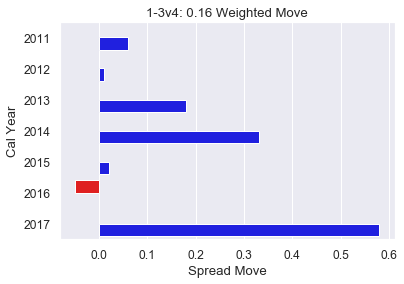

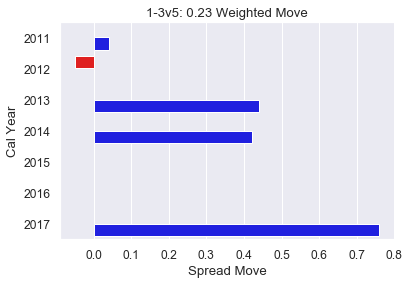

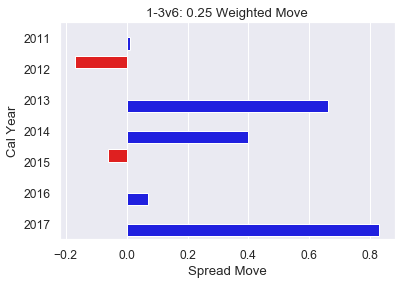

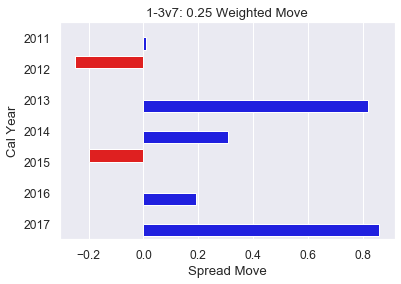

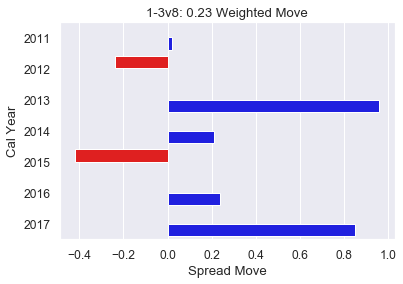

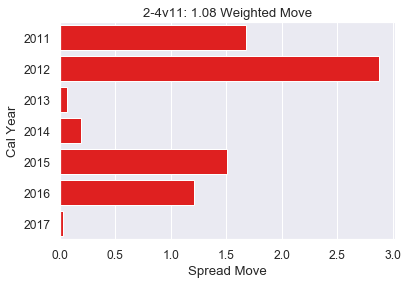

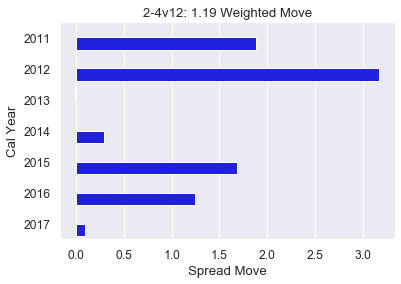

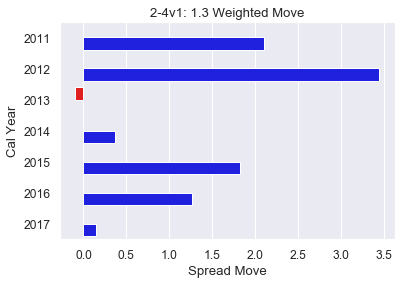

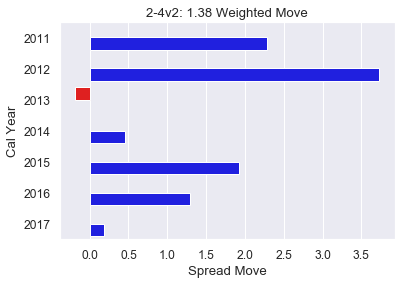

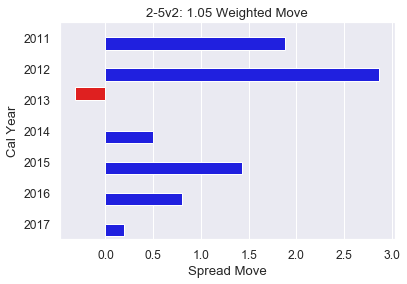

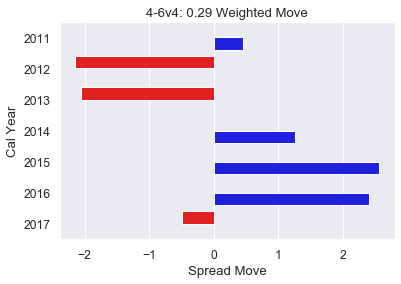

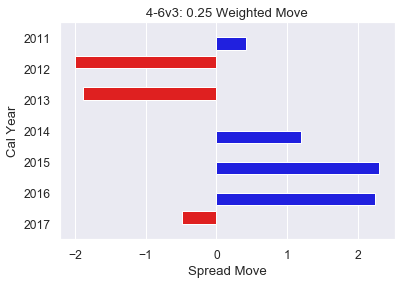

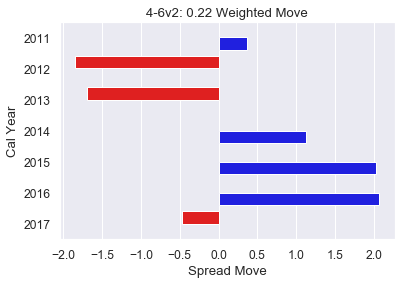

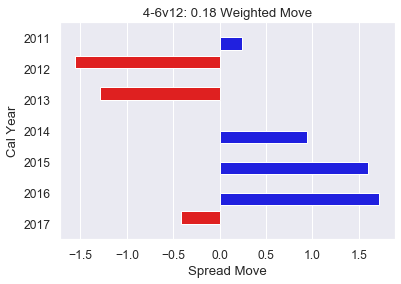

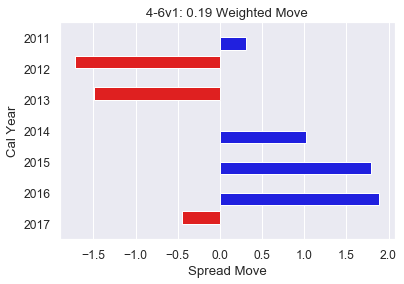

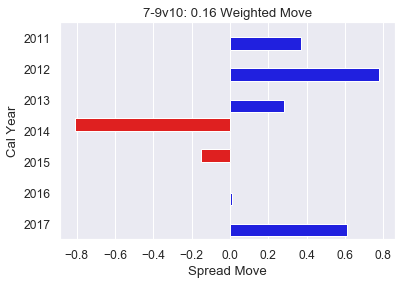

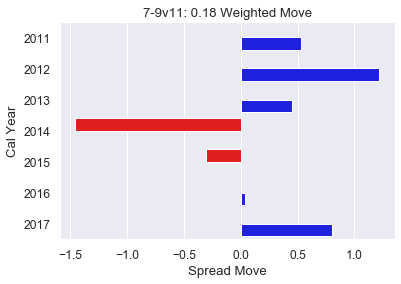

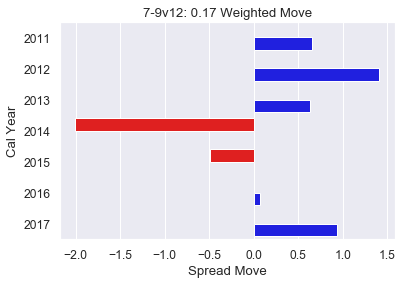

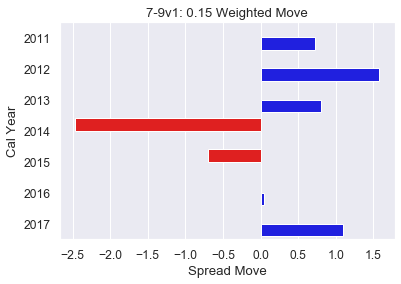

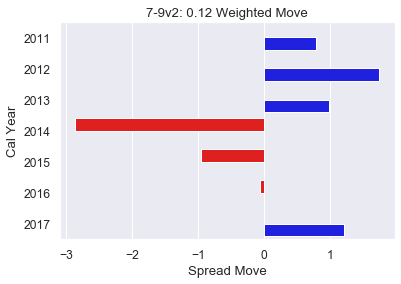

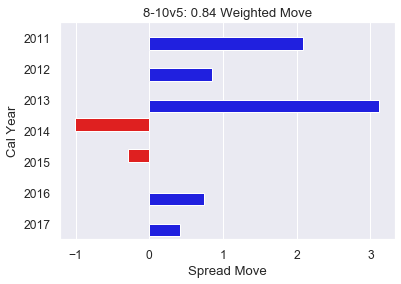

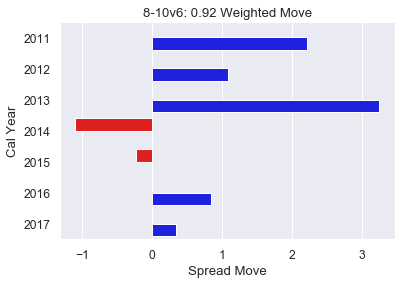

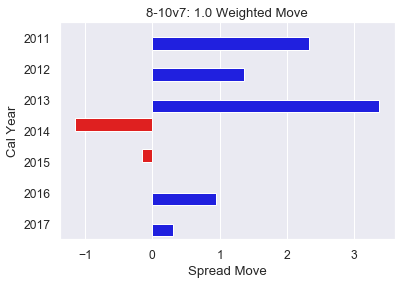

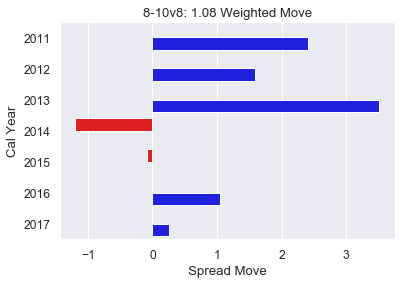

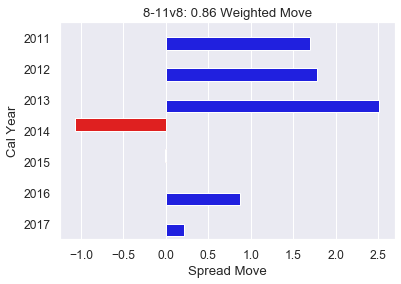

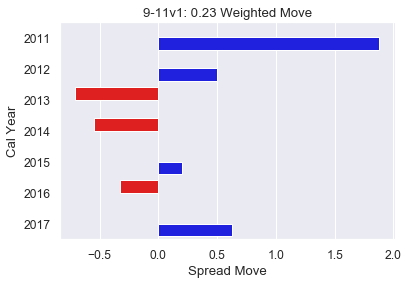

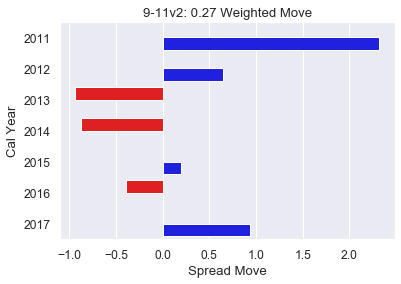

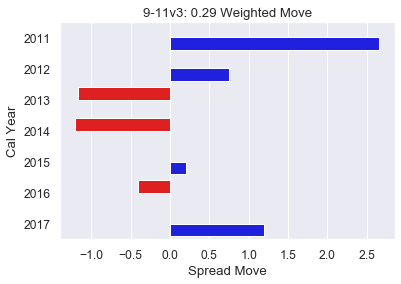

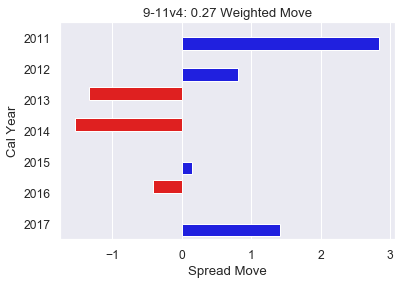

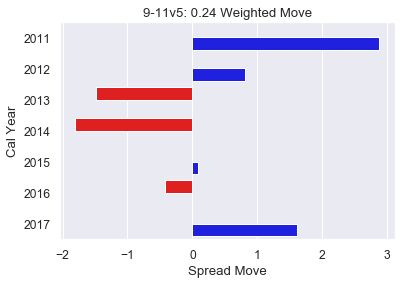

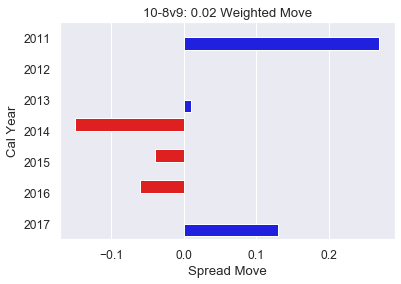

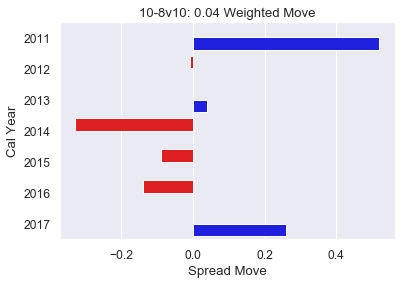

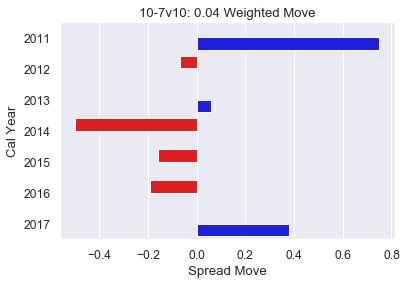

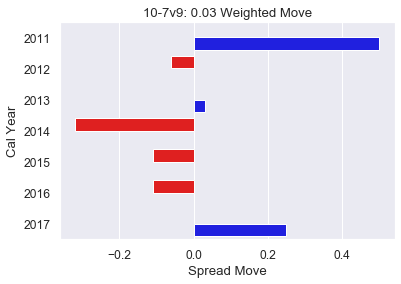

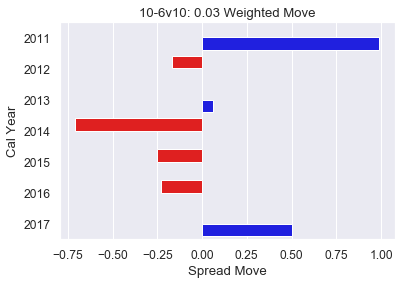

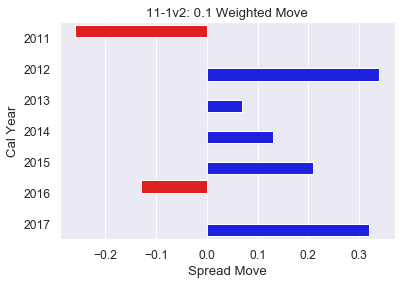

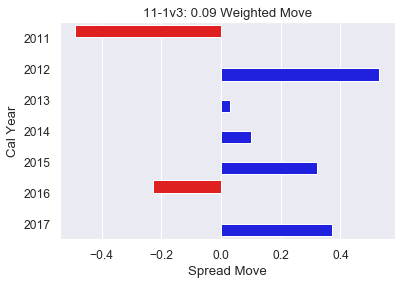

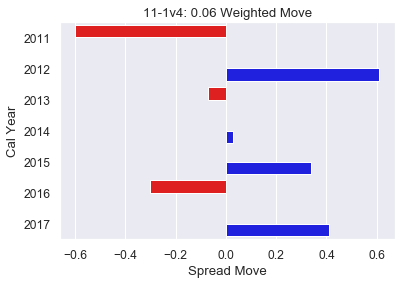

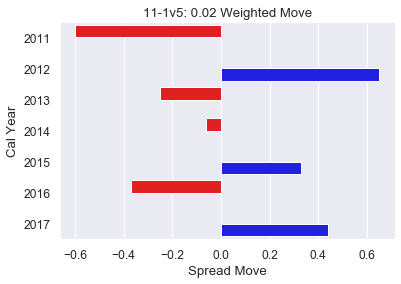

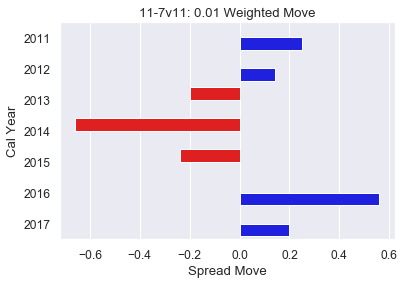

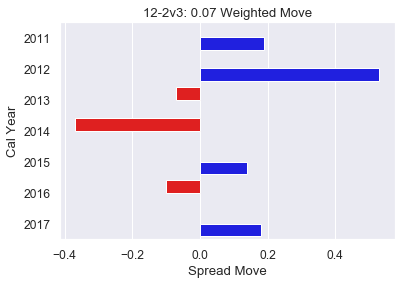

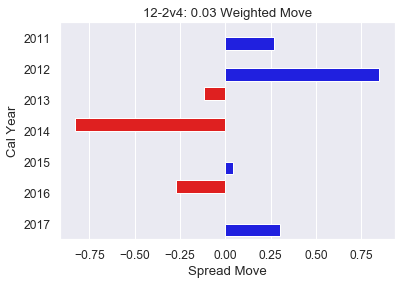

In [38]:
#Plot best up trades
print('Best Bull Trades:')    
#Plot best up trades    
up_spreads = trades_upF['calmonth_spread_label'].unique()
for spread in up_spreads:
    sns_barplot(df=stats, spread=spread, x_name='Mo_Move', y_name='Cal Year', hue_name='Mo_Up')  

Best Bear Trades:


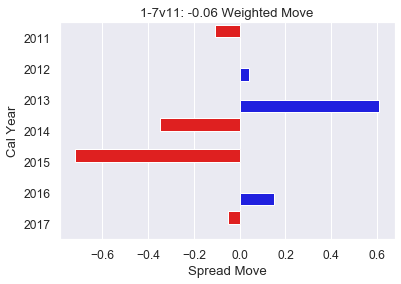

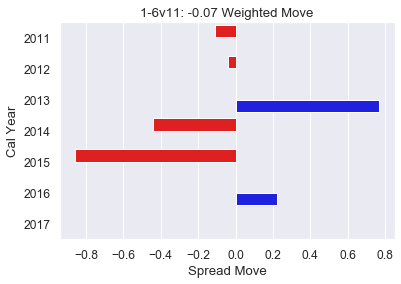

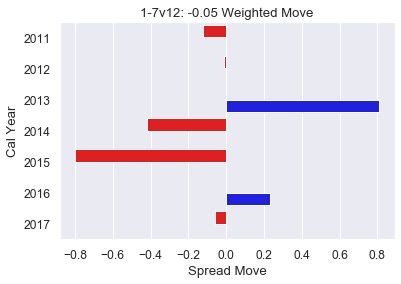

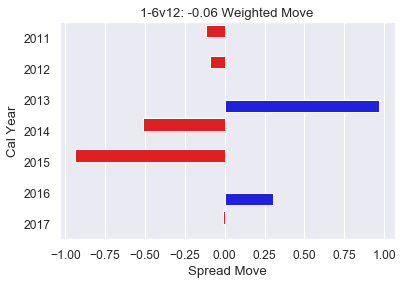

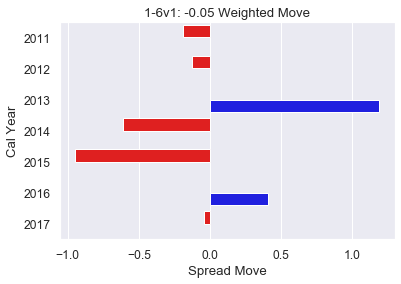

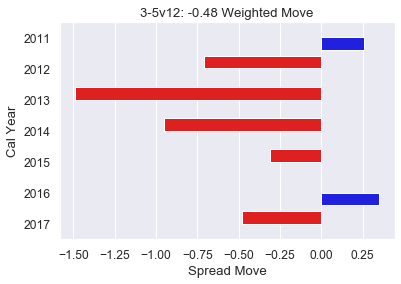

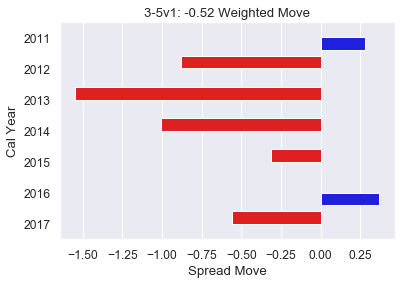

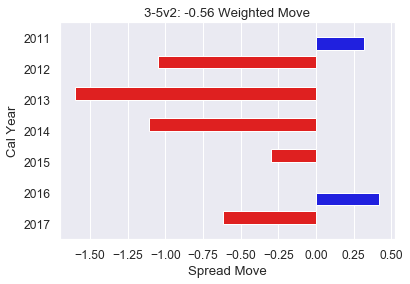

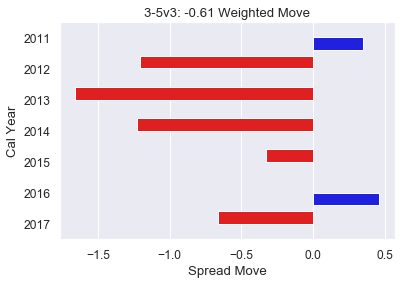

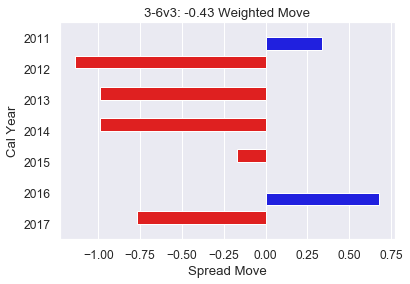

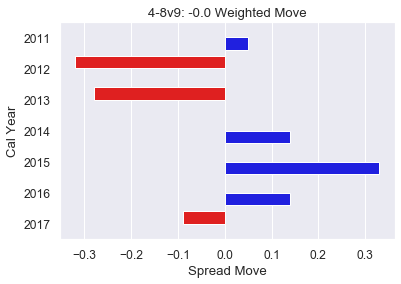

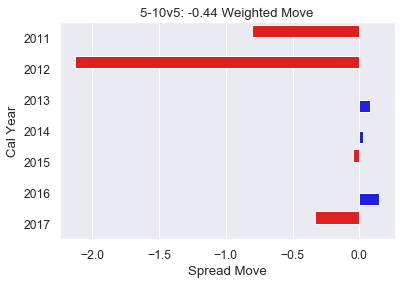

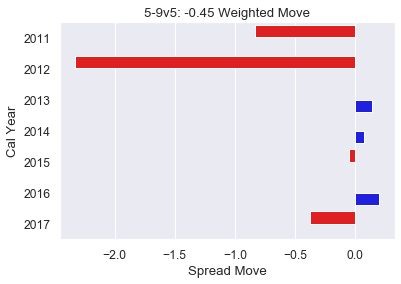

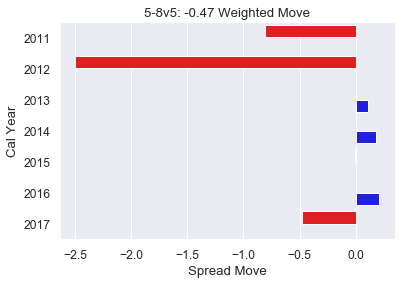

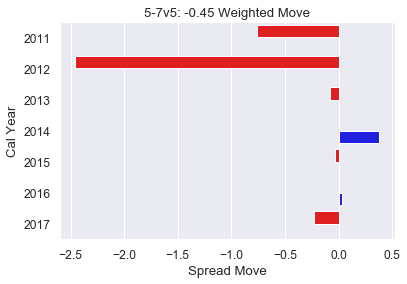

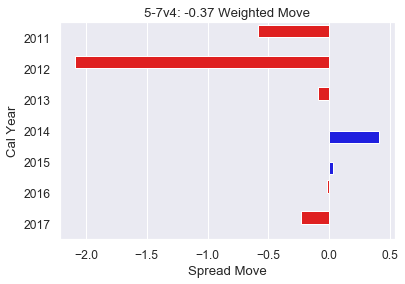

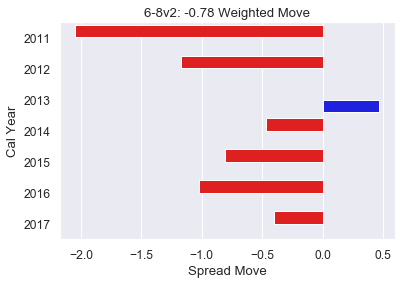

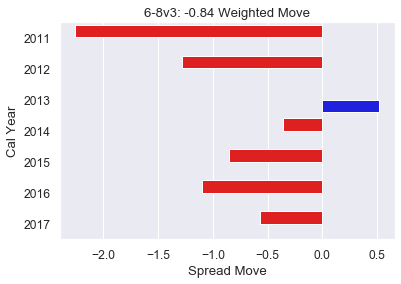

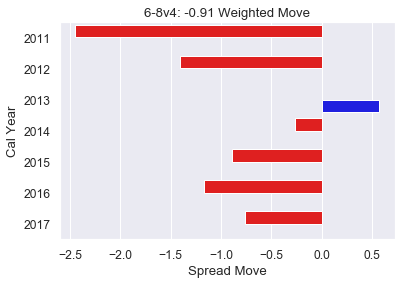

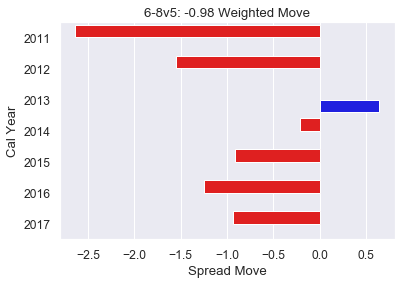

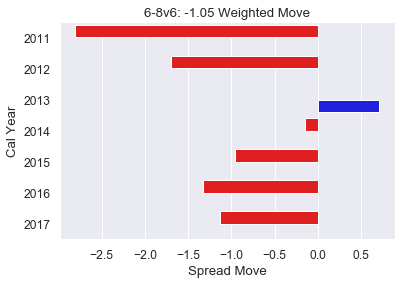

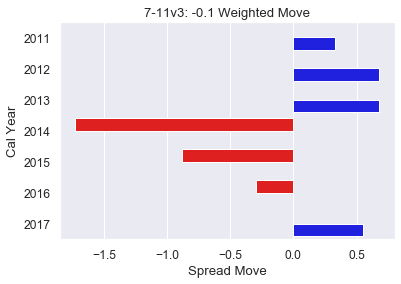

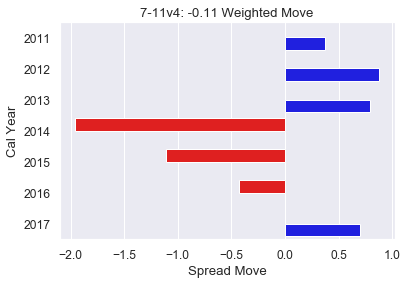

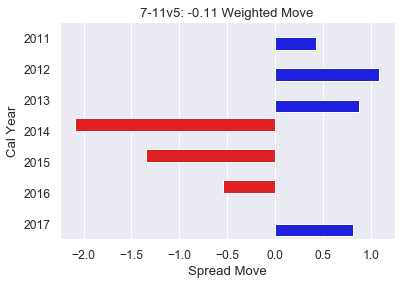

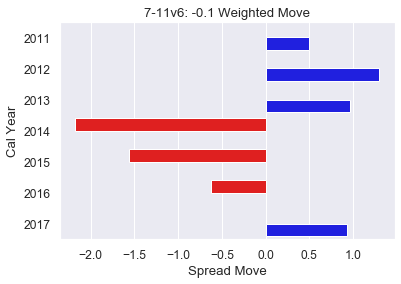

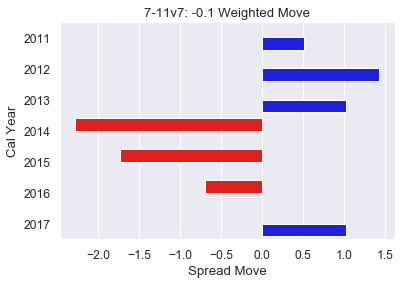

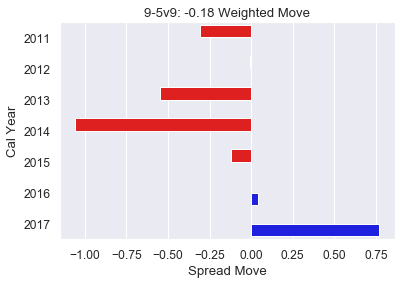

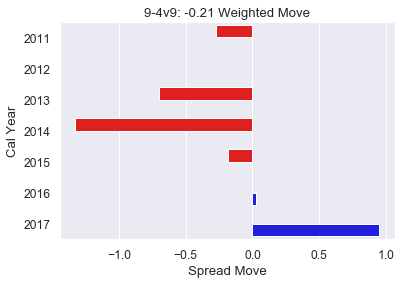

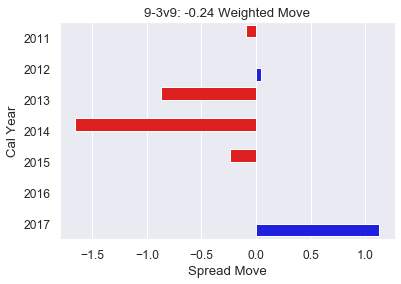

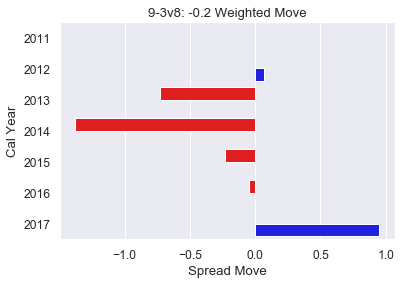

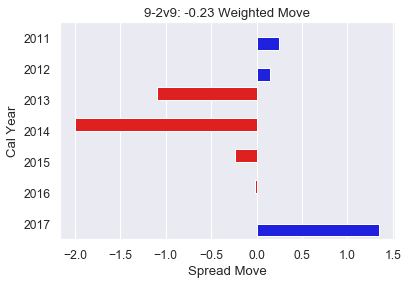

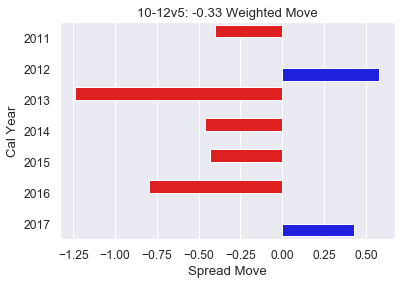

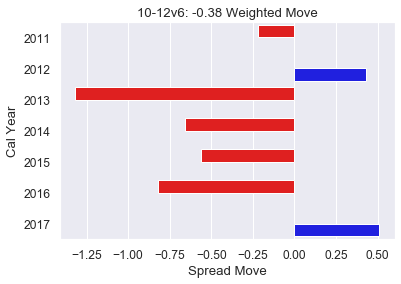

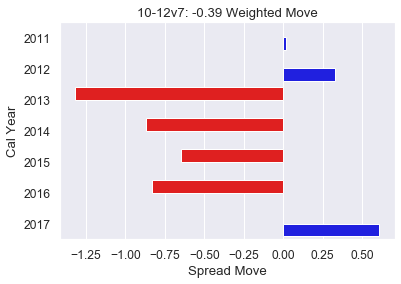

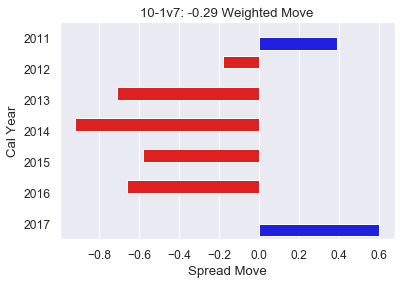

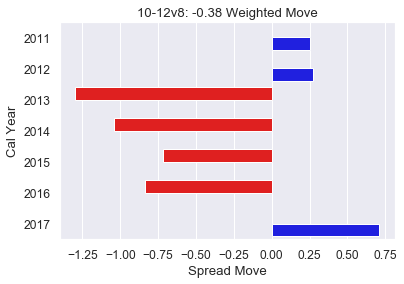

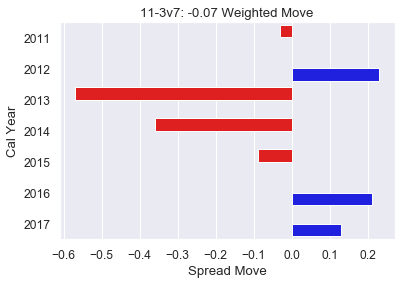

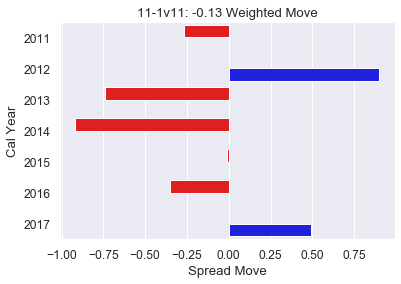

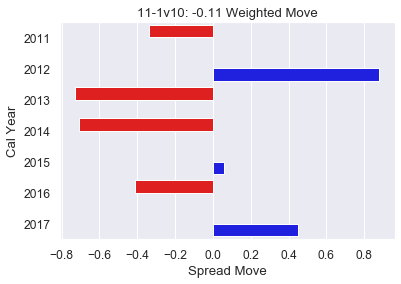

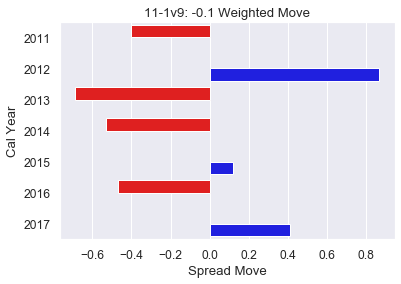

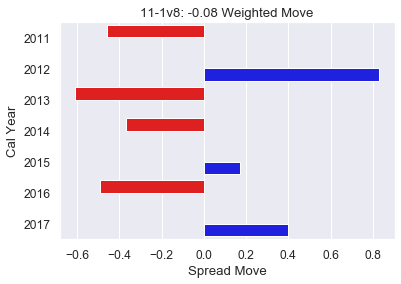

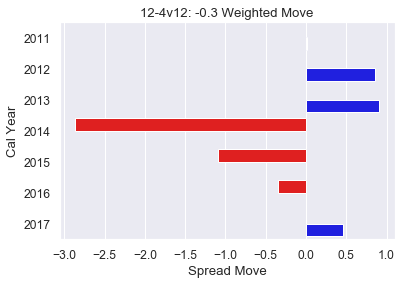

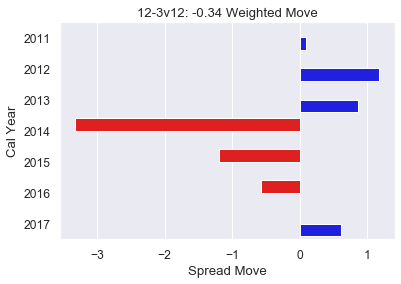

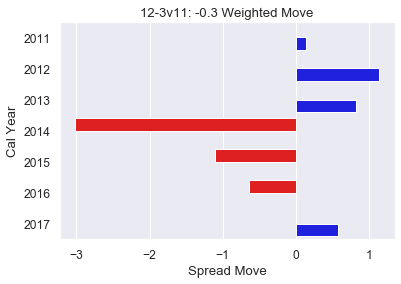

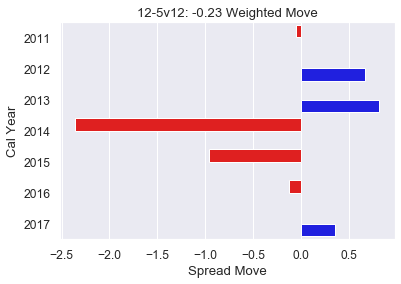

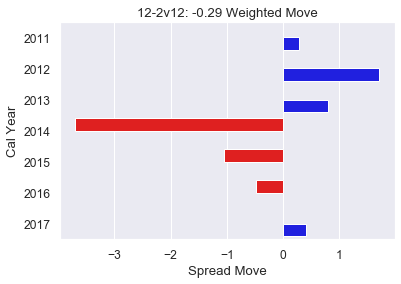

In [39]:
#Plot best dn trades
print('Best Bear Trades:')
dn_spreads = trades_dnF['calmonth_spread_label'].unique()
for spread in dn_spreads:
    sns_barplot(df=stats, spread=spread, x_name='Mo_Move', y_name='Cal Year', hue_name='Mo_Up') 

In [40]:
tsFinal.head()

Date product  Cal Year  Cal Month  spread calmonth_spread_label   DoD  \
0 2011-01-03   BRENT      2011          1   -0.01                1-10v1   NaN   
1 2011-01-04   BRENT      2011          1   -0.11                1-10v1 -0.10   
2 2011-01-05   BRENT      2011          1   -0.17                1-10v1 -0.06   
3 2011-01-06   BRENT      2011          1   -0.26                1-10v1 -0.09   
4 2011-01-07   BRENT      2011          1   -0.24                1-10v1  0.02   

   DoD_Up  Mo_Move  Mo_Up  DoD_Up_Prob  Mo_Up_Pct  Mo_Dn_Pct  Mo_Up_Amt  \
0     NaN    -0.11    0.0      0.47619   0.285714   0.714286       0.41   
1     0.0    -0.11    0.0      0.47619   0.285714   0.714286       0.41   
2     0.0    -0.11    0.0      0.47619   0.285714   0.714286       0.41   
3     0.0    -0.11    0.0      0.47619   0.285714   0.714286       0.41   
4     1.0    -0.11    0.0      0.47619   0.285714   0.714286       0.41   

   Mo_Dn_Amt  Mo_Wtd_Move  
0      -0.15         0.01  
1      -0.15         0.01  
2      -0.15         0.01  
3      -0.15         0.01  
4      -0.15         0.01

In [41]:
#Plot spread daily z-scores - fit period
def z_plot_spreads(df, z_column, cml):
    
    match = re.search("([0-9]?[0-9])[-]", cml)   #infer month from spread
    month = int(match.group(1))
                       
    mask = (df['calmonth_spread_label'] == cml)
    dfM = tsFinal.loc[mask, :].copy()
    mu = dfM[z_column].mean()
    sigma = dfM[z_column].std()
    mo_wtd_move = dfM.iloc[0,-1]
    dfM['z_scores'] = (dfM[z_column] - mu) / sigma  #omits "initial price" z-score
            
    #Get initial price row.
    beg_day_df = get_init_price(df=df, init_days=initial_days_fit, cml=cml, calmonth=month)
    beg_spr = beg_day_df[z_column].values[0]
        
    #get z-scores
    exp_end_spr = beg_spr + mo_wtd_move  #cml Move **NOT** prev_cml
    beg_spr_z = (beg_spr - mu) / sigma
    exp_end_spr_z = (exp_end_spr - mu) / sigma
    z_diff = exp_end_spr_z - beg_spr_z
    
    print('Begin spread z:', round(beg_spr_z,2), 'Expected End Spread z:', round(exp_end_spr_z,2))
          
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.set(font_scale=1.2)
    ax=sns.distplot(dfM['z_scores'], kde=True, norm_hist=False)
    ax.set_title(f'{cml} \nCents - Begin spread: {round(beg_spr,2)}; Expected Mo Move: {round(mo_wtd_move,2)}; Expected End Spread: {round(exp_end_spr,2)}')
    
    plt.axvline(beg_spr_z, 0, 1, linestyle = 'dashed', color = 'orange')
    plt.axvline(exp_end_spr_z, 0, 1, linestyle = 'dashed', color = 'black')
    plt.show()
    return

Best Bull Trades:

Begin spread z: -0.81 Expected End Spread z: -0.58


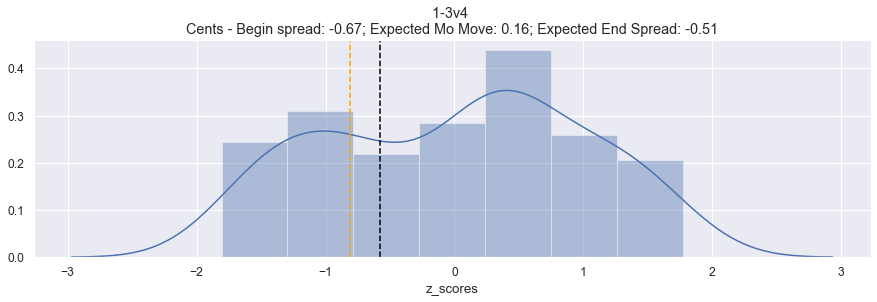

Begin spread z: -0.71 Expected End Spread z: -0.53


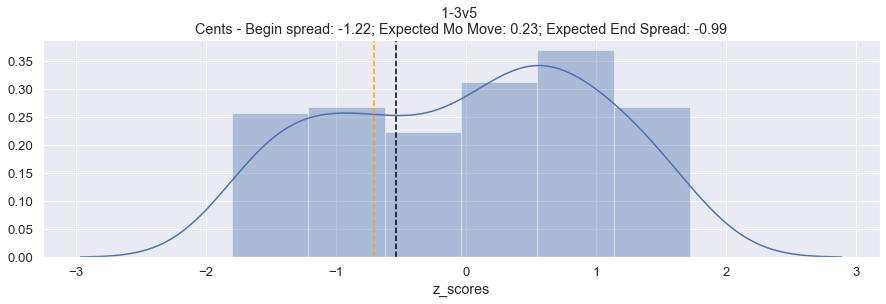

Begin spread z: -0.61 Expected End Spread z: -0.48


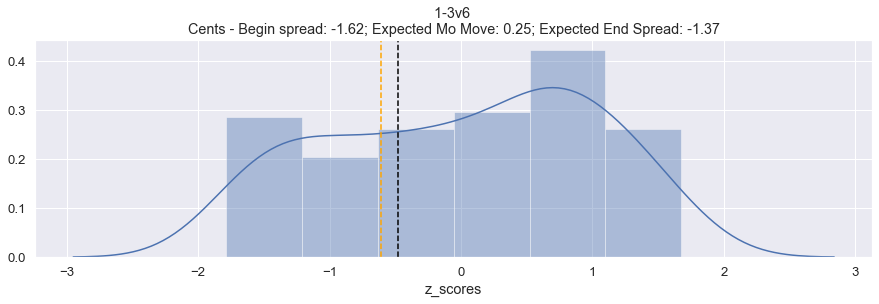

Begin spread z: -0.53 Expected End Spread z: -0.43


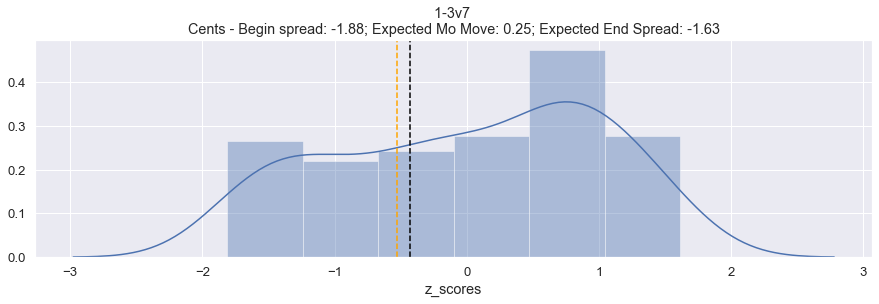

Begin spread z: -0.46 Expected End Spread z: -0.38


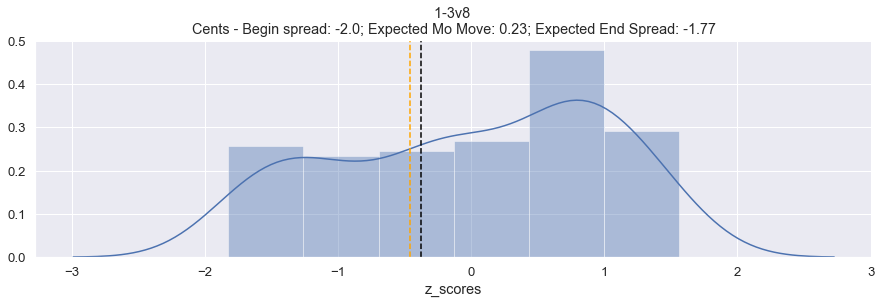

Begin spread z: -0.26 Expected End Spread z: 0.0


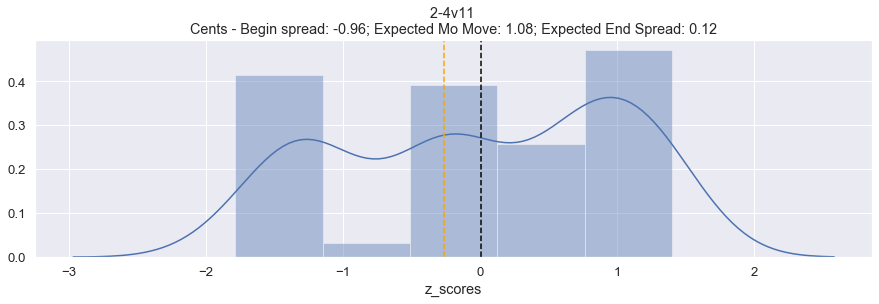

Begin spread z: -0.25 Expected End Spread z: 0.02


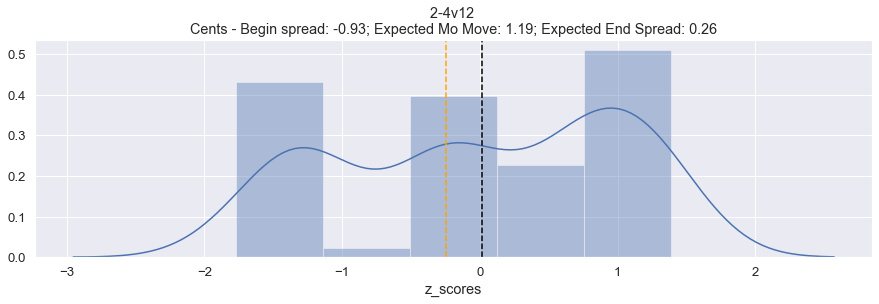

Begin spread z: -0.23 Expected End Spread z: 0.03


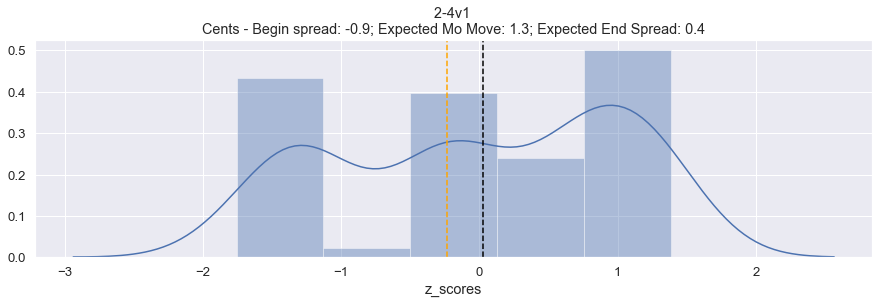

Begin spread z: -0.22 Expected End Spread z: 0.04


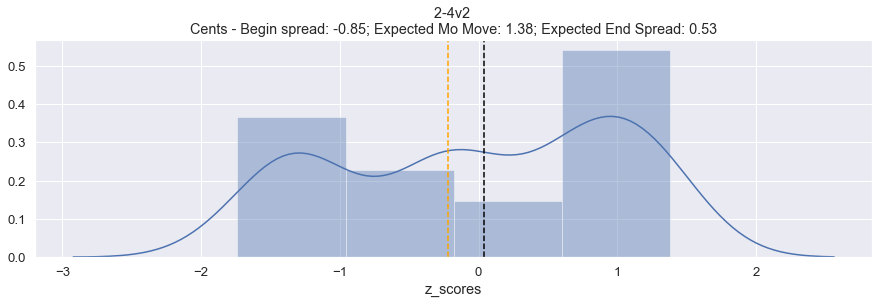

Begin spread z: -0.17 Expected End Spread z: 0.05


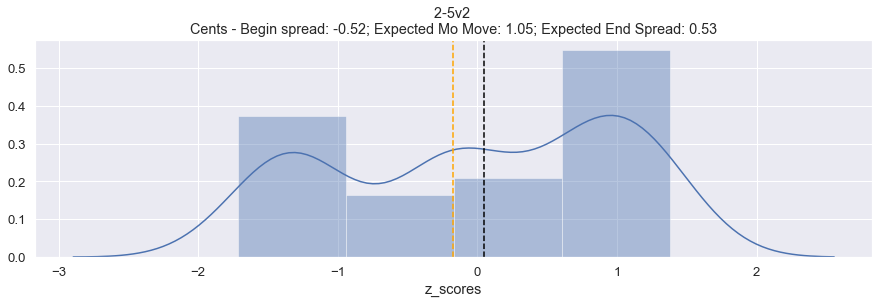

Begin spread z: -0.43 Expected End Spread z: -0.35


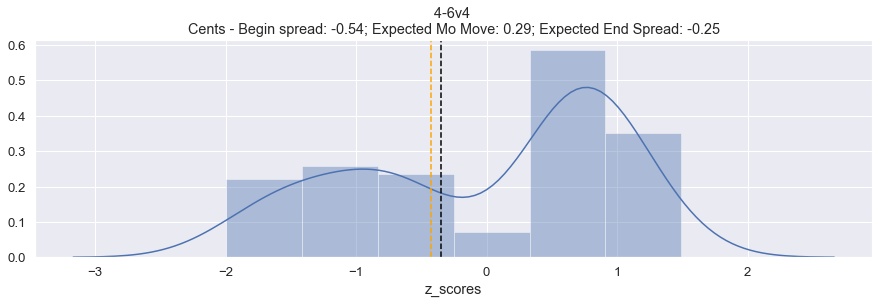

Begin spread z: -0.44 Expected End Spread z: -0.37


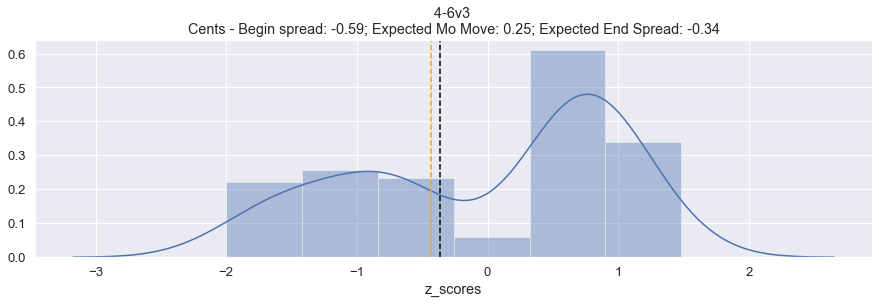

Begin spread z: -0.45 Expected End Spread z: -0.38


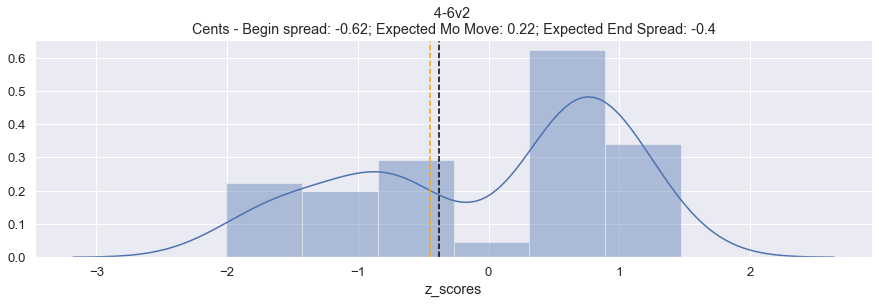

Begin spread z: -0.47 Expected End Spread z: -0.4


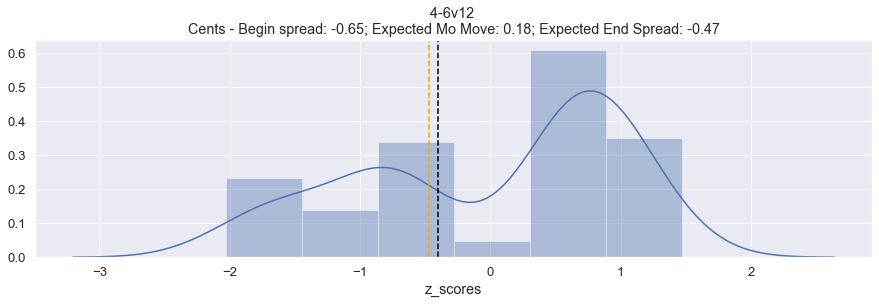

Begin spread z: -0.46 Expected End Spread z: -0.39


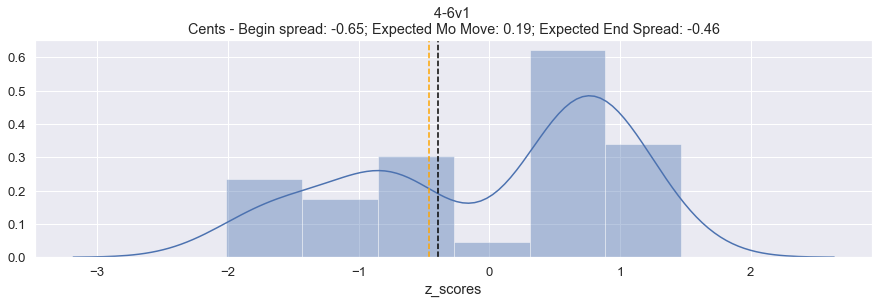

Begin spread z: -0.58 Expected End Spread z: -0.27


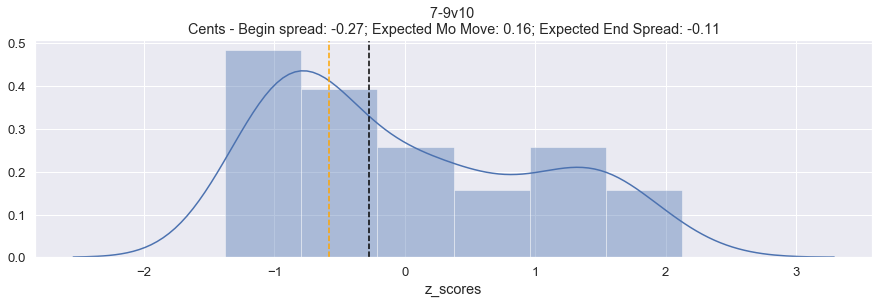

Begin spread z: -0.59 Expected End Spread z: -0.38


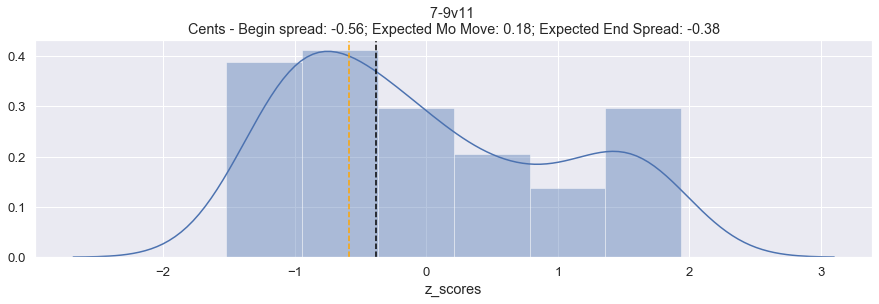

Begin spread z: -0.56 Expected End Spread z: -0.43


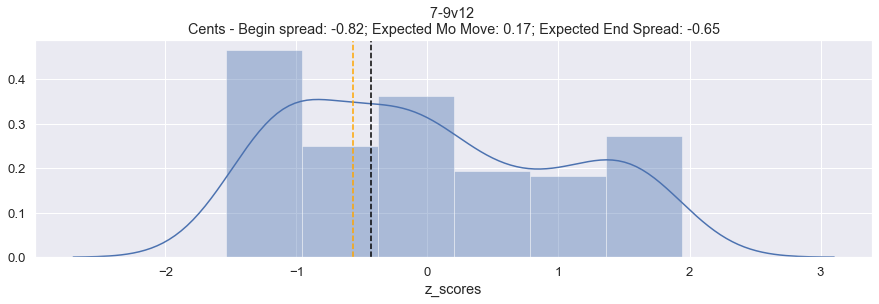

Begin spread z: -0.58 Expected End Spread z: -0.49


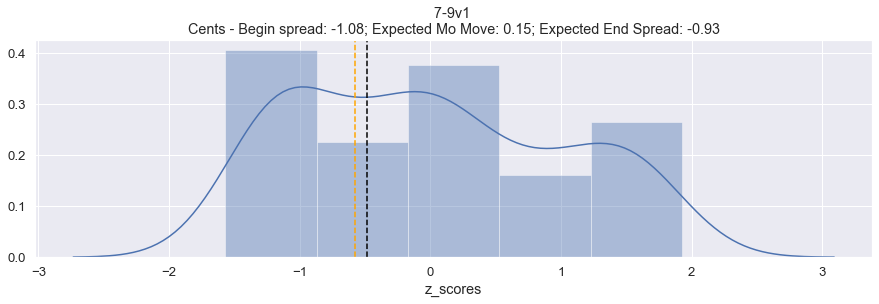

Begin spread z: -0.59 Expected End Spread z: -0.53


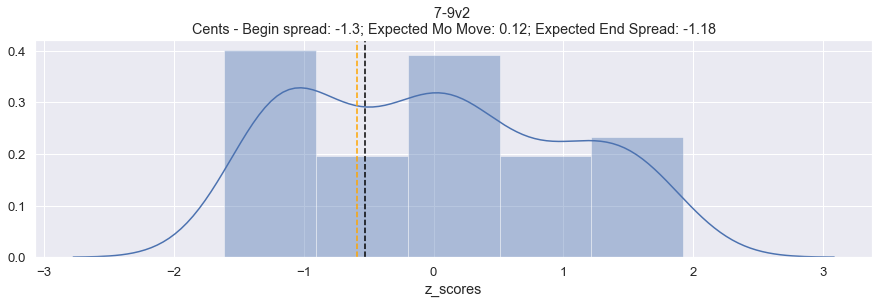

Begin spread z: -0.24 Expected End Spread z: 0.02


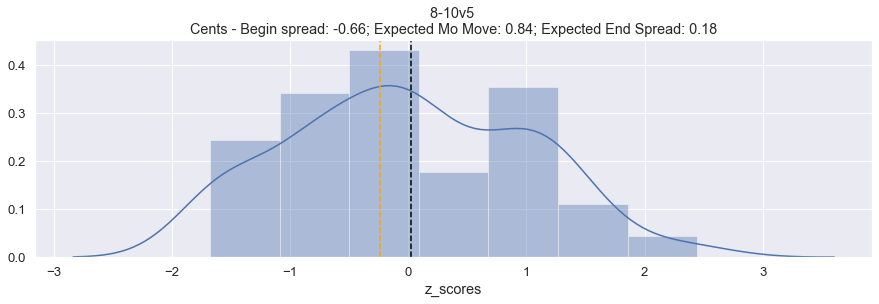

Begin spread z: -0.24 Expected End Spread z: 0.01


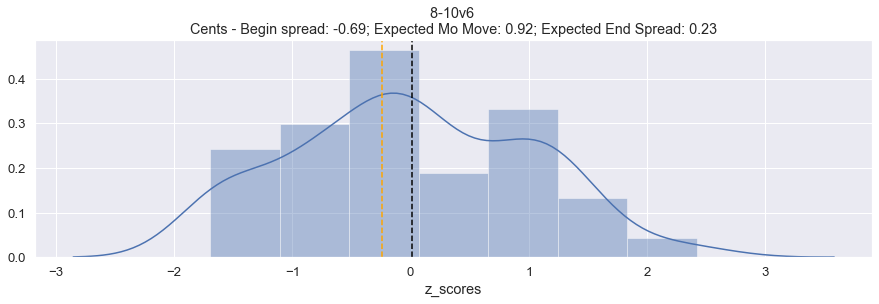

Begin spread z: -0.25 Expected End Spread z: 0.01


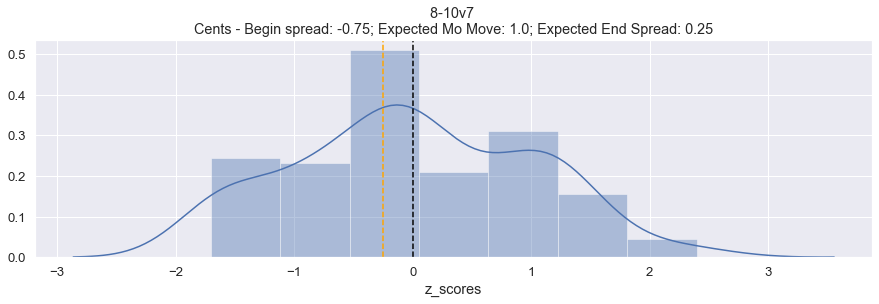

Begin spread z: -0.26 Expected End Spread z: -0.01


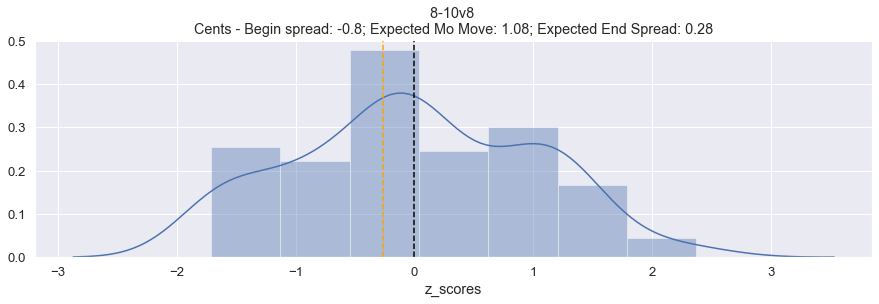

Begin spread z: -0.24 Expected End Spread z: 0.0


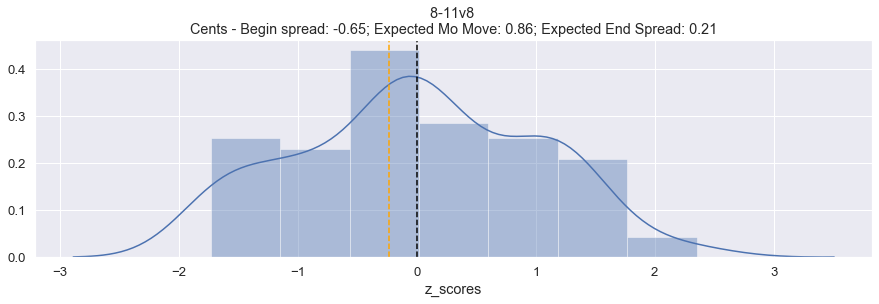

Begin spread z: -0.19 Expected End Spread z: -0.02


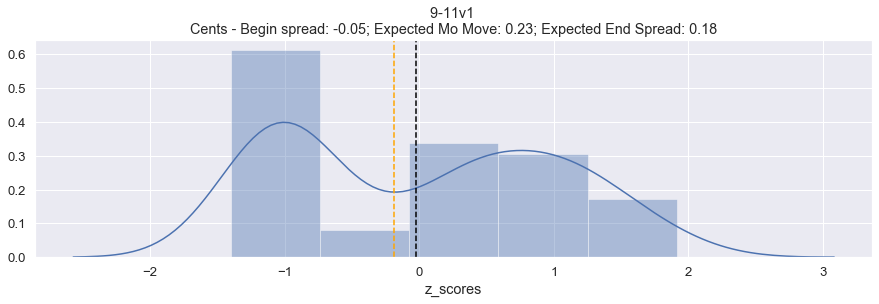

Begin spread z: -0.2 Expected End Spread z: -0.06


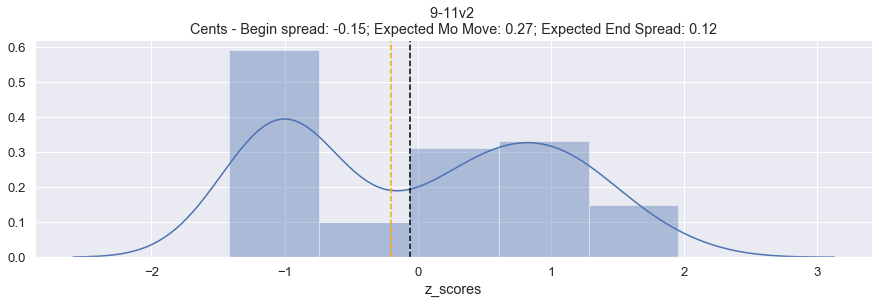

Begin spread z: -0.21 Expected End Spread z: -0.09


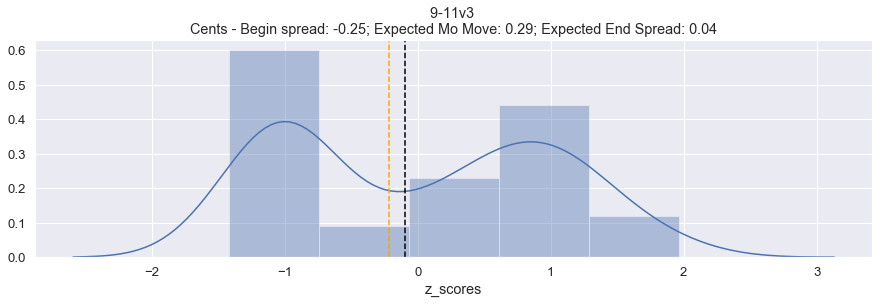

Begin spread z: -0.22 Expected End Spread z: -0.12


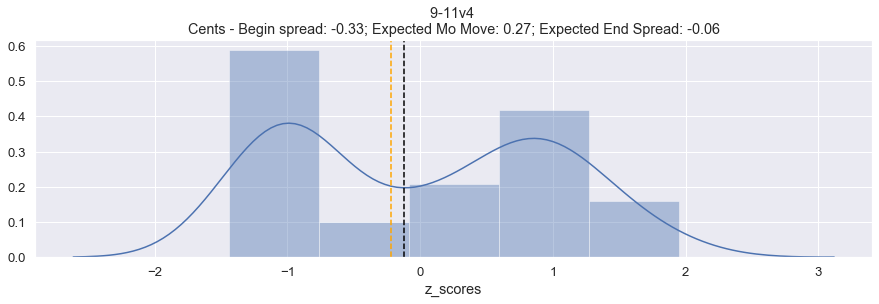

Begin spread z: -0.23 Expected End Spread z: -0.16


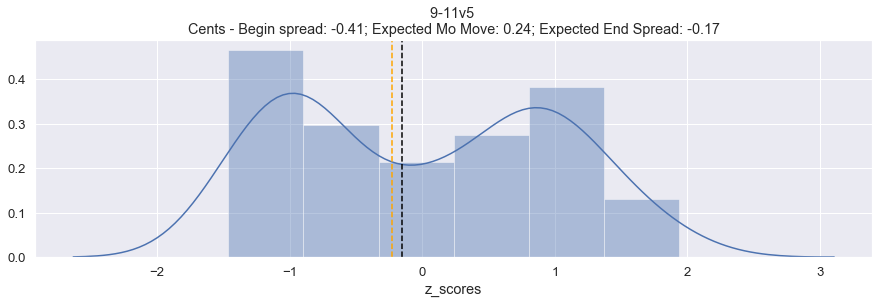

Begin spread z: -0.02 Expected End Spread z: 0.04


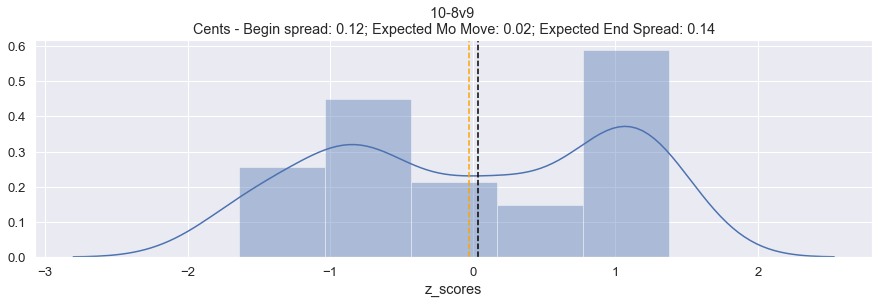

Begin spread z: -0.05 Expected End Spread z: -0.0


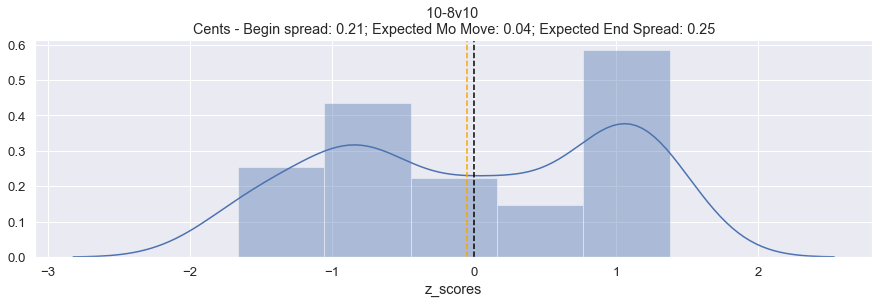

Begin spread z: -0.02 Expected End Spread z: 0.01


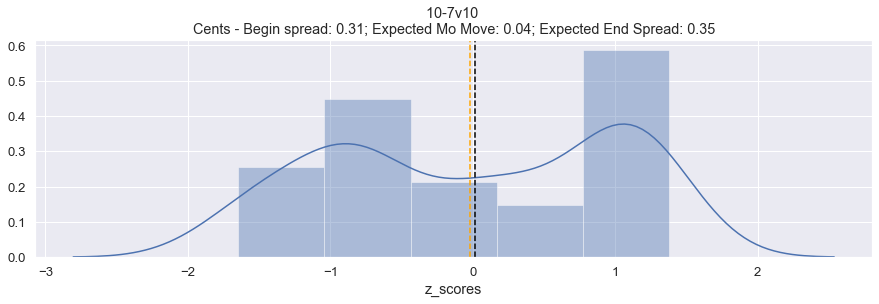

Begin spread z: 0.01 Expected End Spread z: 0.04


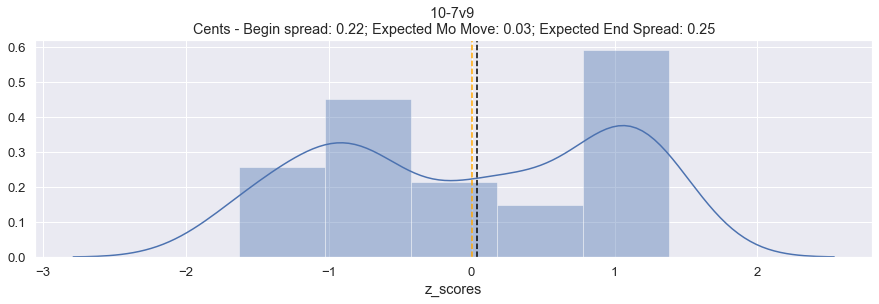

Begin spread z: 0.02 Expected End Spread z: 0.04


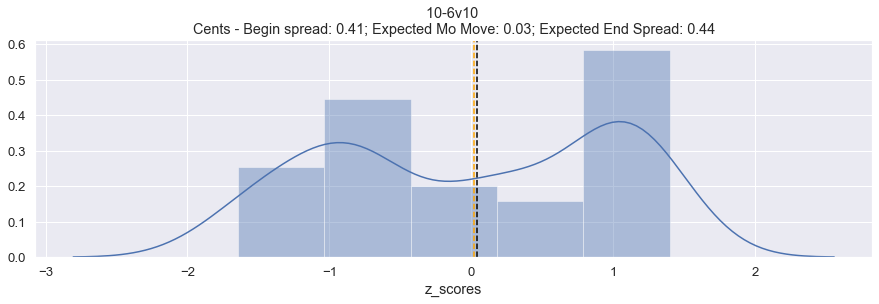

Begin spread z: 0.48 Expected End Spread z: 0.62


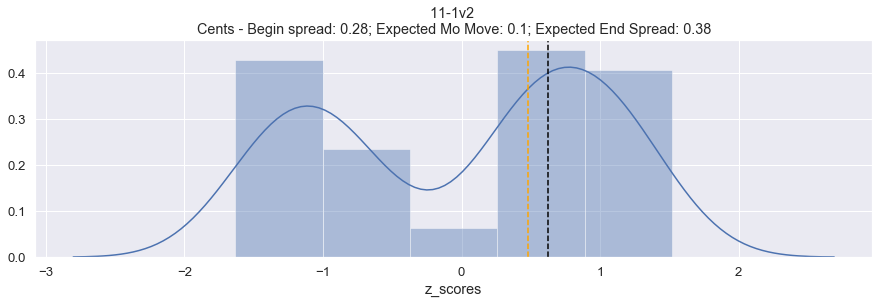

Begin spread z: 0.47 Expected End Spread z: 0.54


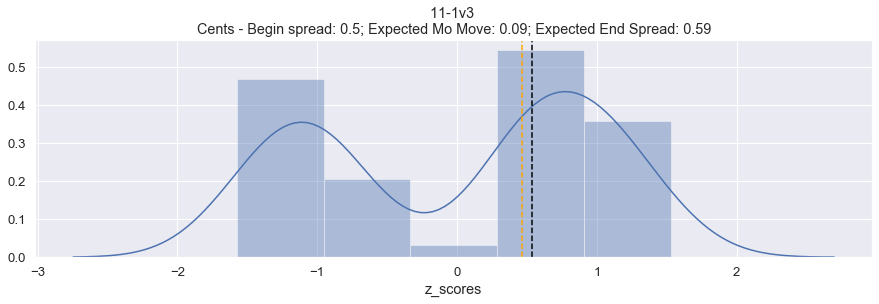

Begin spread z: 0.49 Expected End Spread z: 0.52


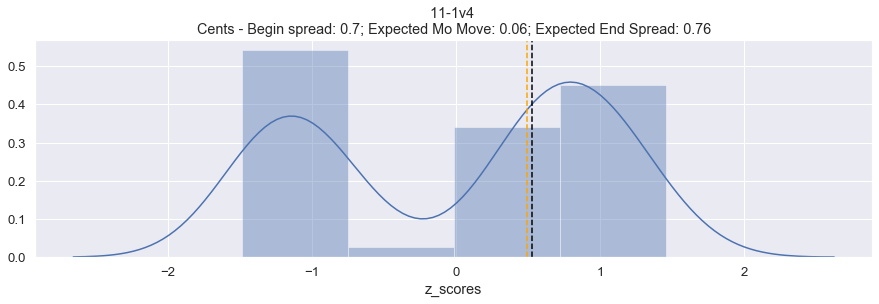

Begin spread z: 0.5 Expected End Spread z: 0.51


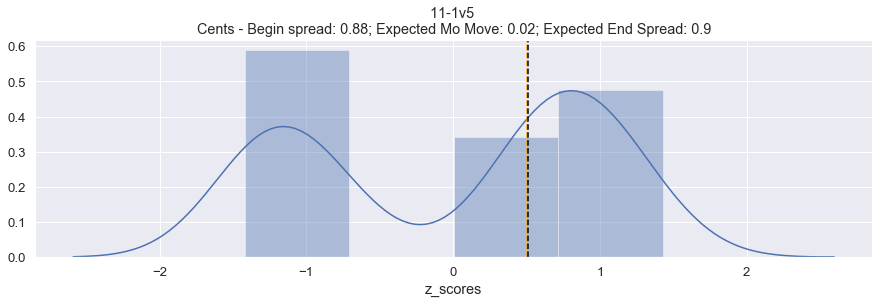

Begin spread z: 0.4 Expected End Spread z: 0.41


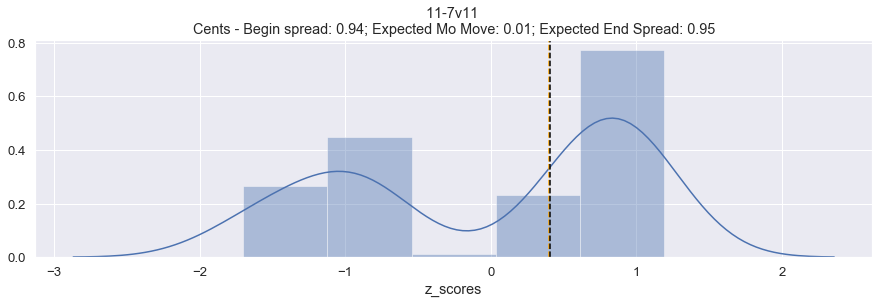

Begin spread z: 0.47 Expected End Spread z: 0.58


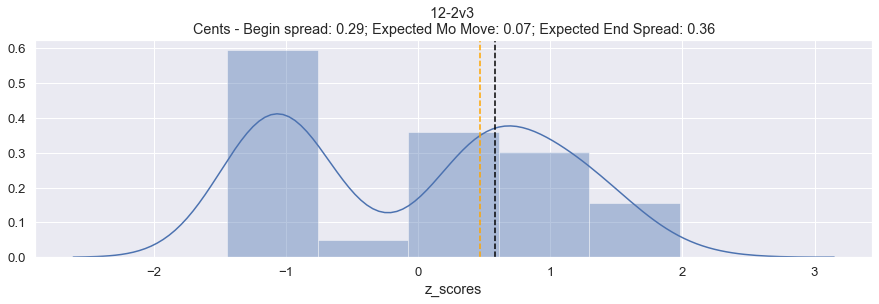

Begin spread z: 0.55 Expected End Spread z: 0.58


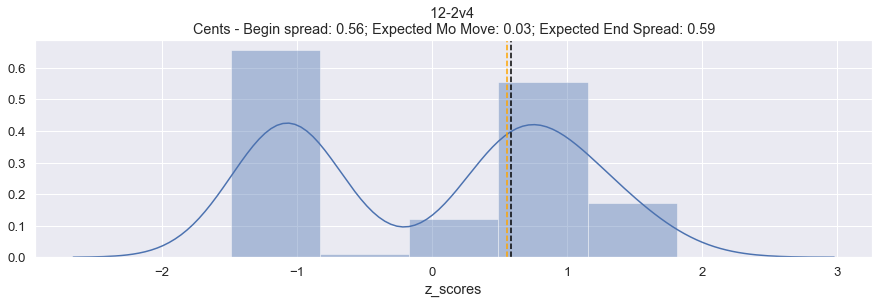

In [42]:
print('Best Bull Trades:\n')
for spread in up_spreads:
    try:
        z_plot_spreads(df=tsFinal, z_column='spread', cml=spread)
    except:
        print(f'{spread} spread isn\'t available for month.\n')

Best Bear Trades:

Begin spread z: -0.03 Expected End Spread z: -0.06


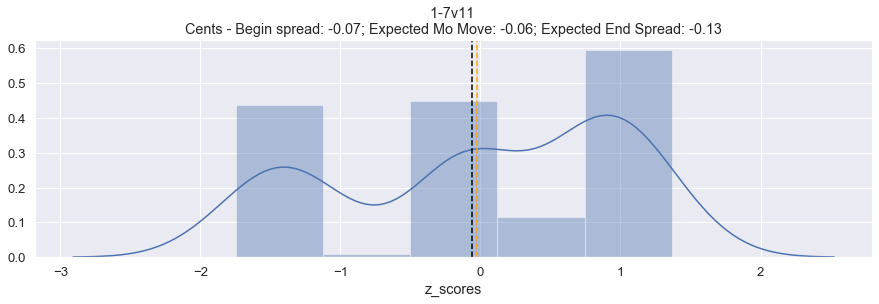

Begin spread z: -0.07 Expected End Spread z: -0.1


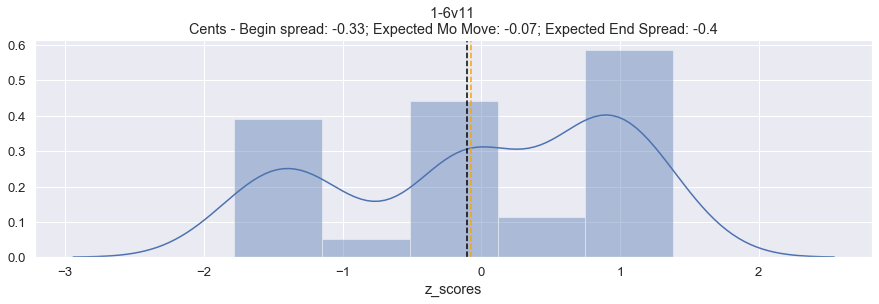

Begin spread z: -0.01 Expected End Spread z: -0.03


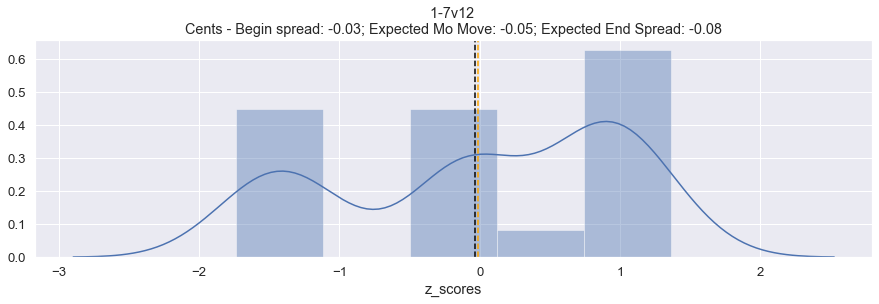

Begin spread z: -0.05 Expected End Spread z: -0.07


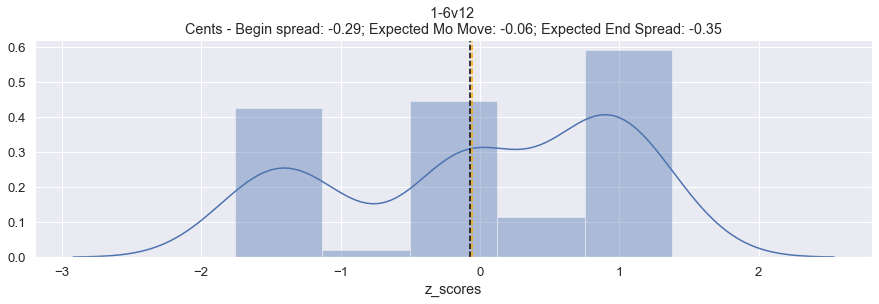

Begin spread z: -0.04 Expected End Spread z: -0.05


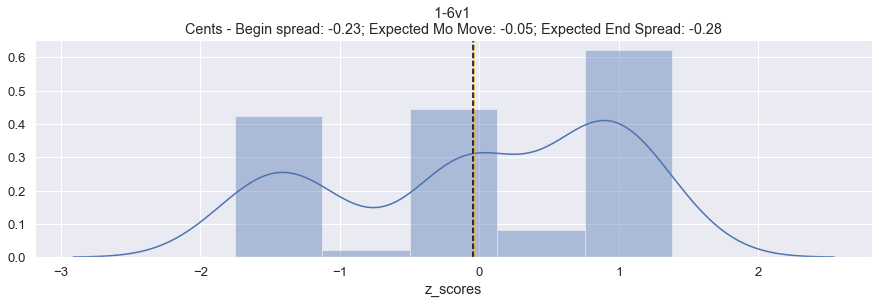

Begin spread z: -0.23 Expected End Spread z: -0.36


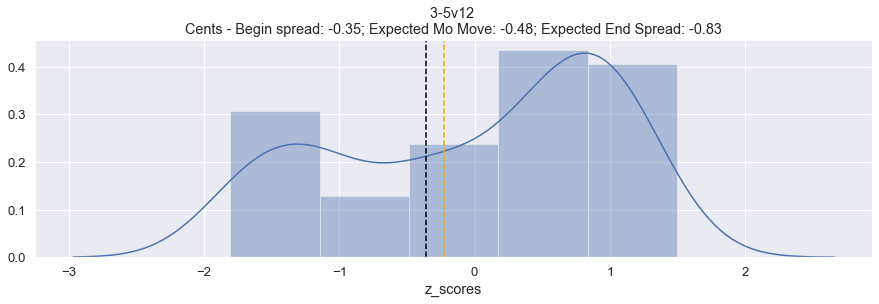

Begin spread z: -0.22 Expected End Spread z: -0.35


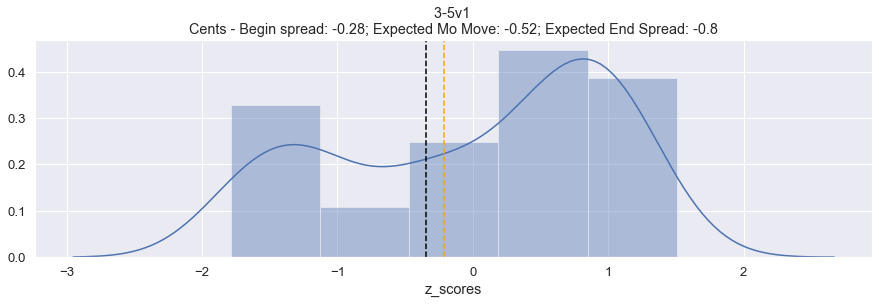

Begin spread z: -0.21 Expected End Spread z: -0.34


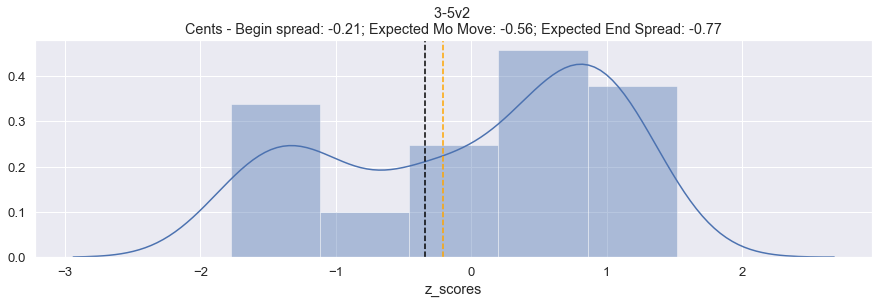

Begin spread z: -0.2 Expected End Spread z: -0.33


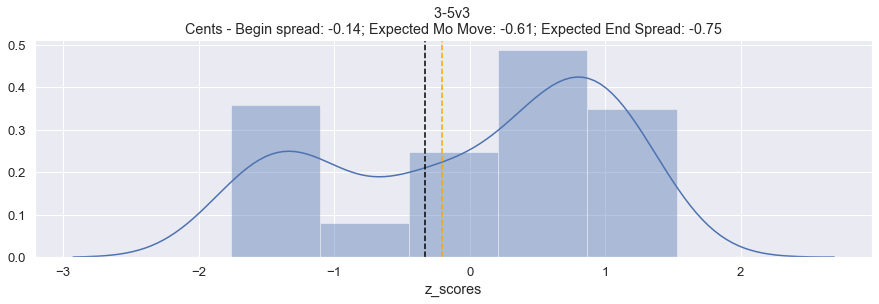

Begin spread z: -0.16 Expected End Spread z: -0.26


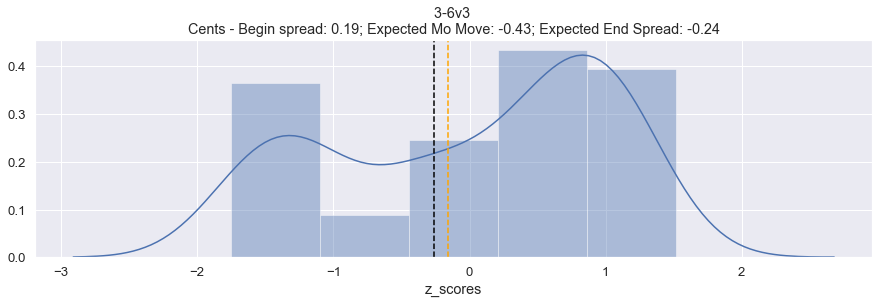

Begin spread z: -0.48 Expected End Spread z: -0.48


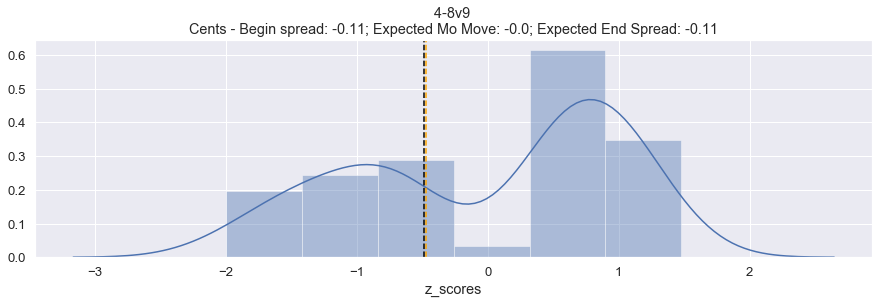

Begin spread z: -0.54 Expected End Spread z: -0.75


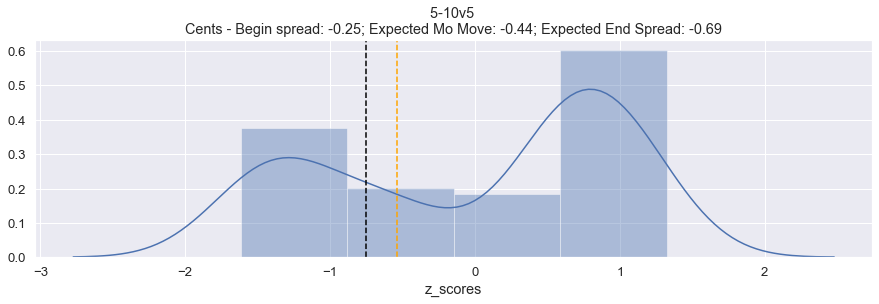

Begin spread z: -0.58 Expected End Spread z: -0.77


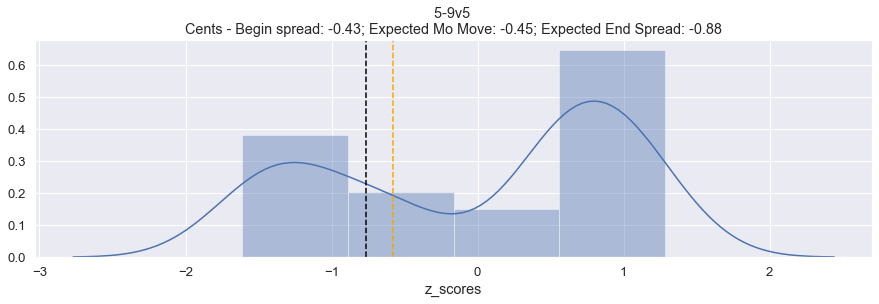

Begin spread z: -0.62 Expected End Spread z: -0.78


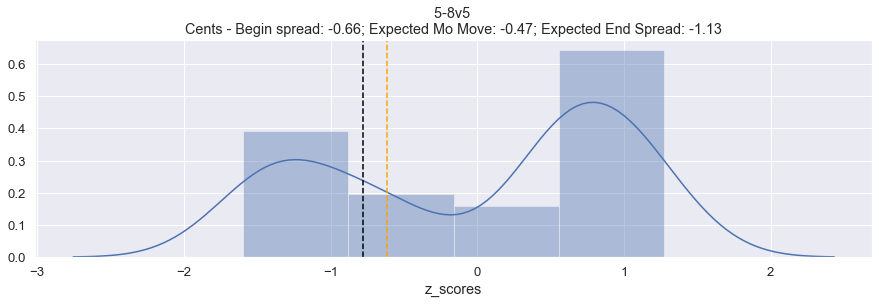

Begin spread z: -0.66 Expected End Spread z: -0.8


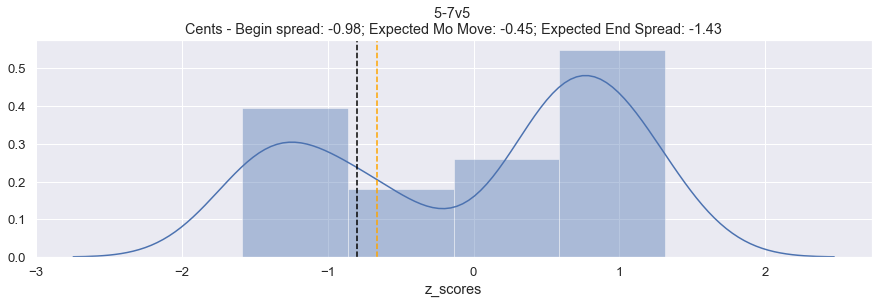

Begin spread z: -0.67 Expected End Spread z: -0.79


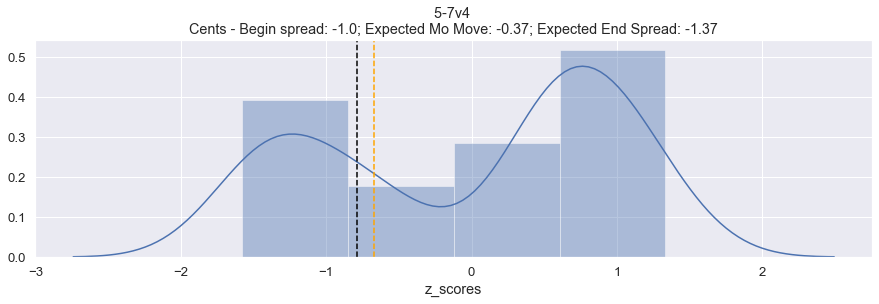

Begin spread z: -0.5 Expected End Spread z: -0.85


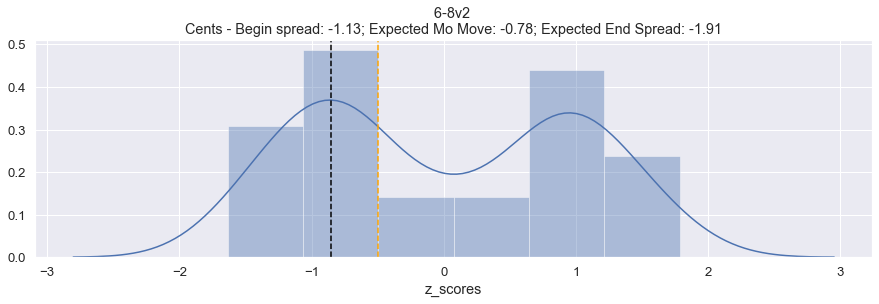

Begin spread z: -0.49 Expected End Spread z: -0.83


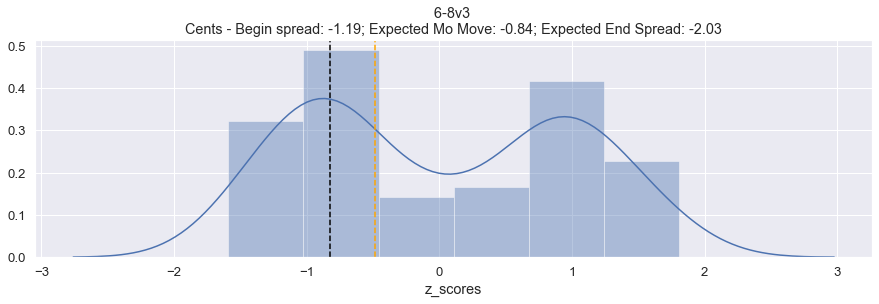

Begin spread z: -0.47 Expected End Spread z: -0.8


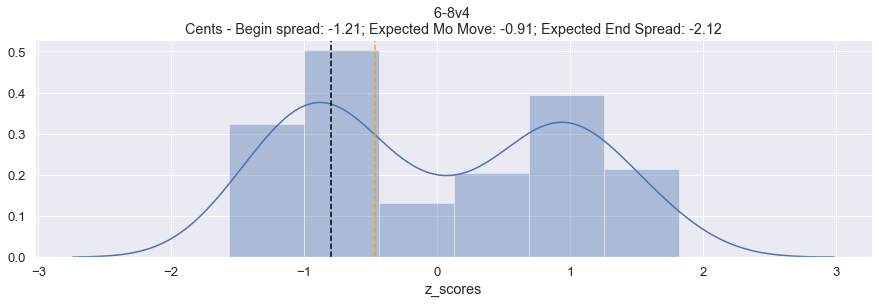

Begin spread z: -0.44 Expected End Spread z: -0.77


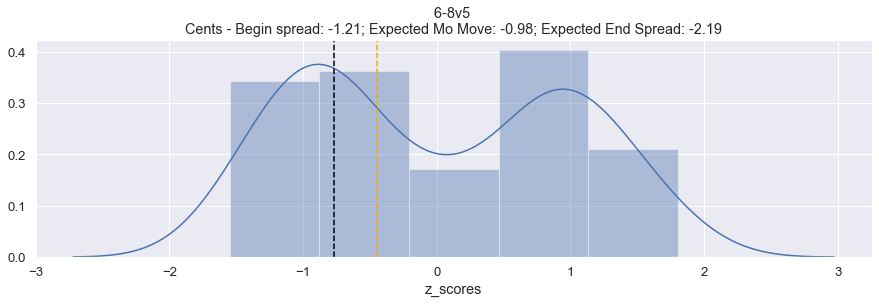

Begin spread z: -0.42 Expected End Spread z: -0.74


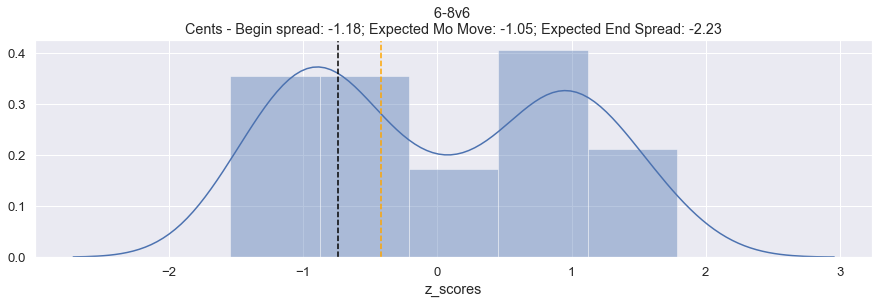

Begin spread z: -0.59 Expected End Spread z: -0.66


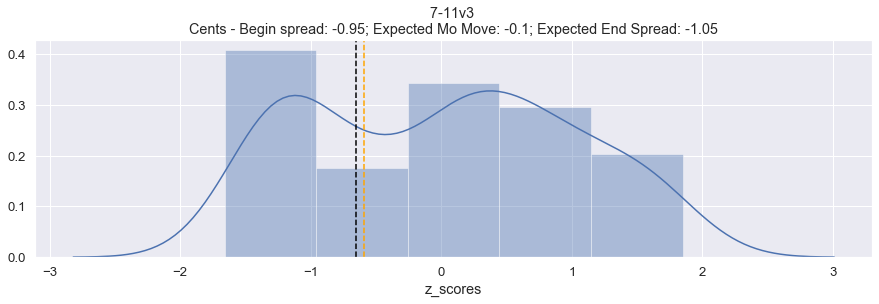

Begin spread z: -0.61 Expected End Spread z: -0.67


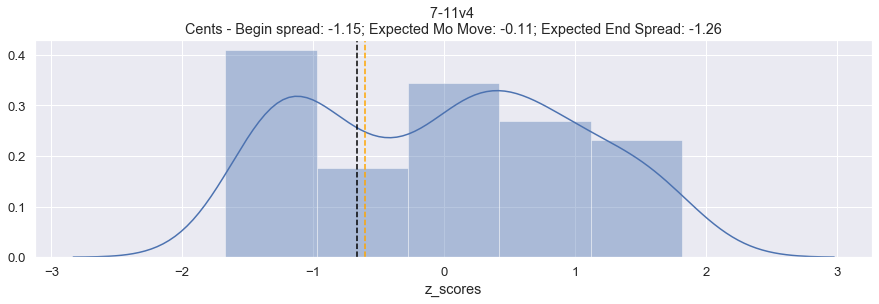

Begin spread z: -0.61 Expected End Spread z: -0.66


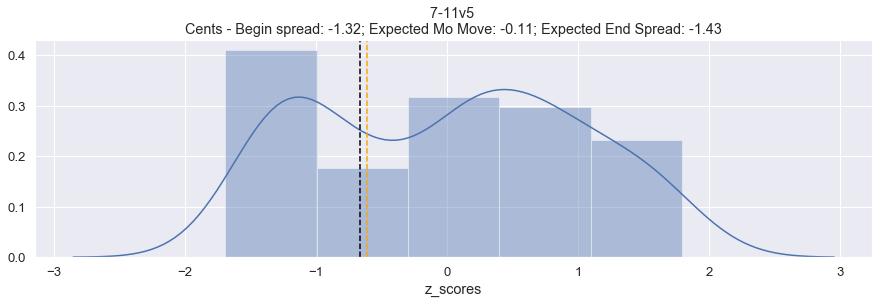

Begin spread z: -0.61 Expected End Spread z: -0.65


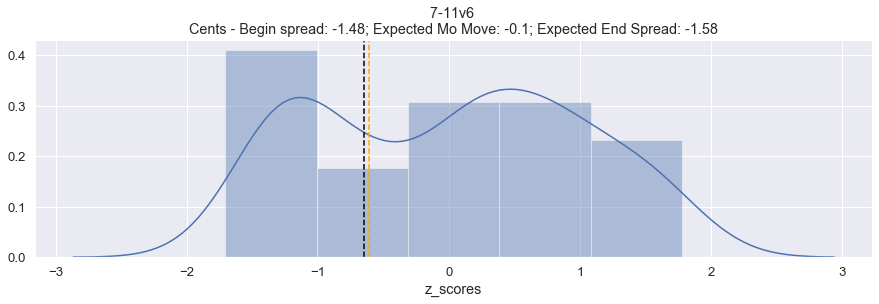

Begin spread z: -0.62 Expected End Spread z: -0.66


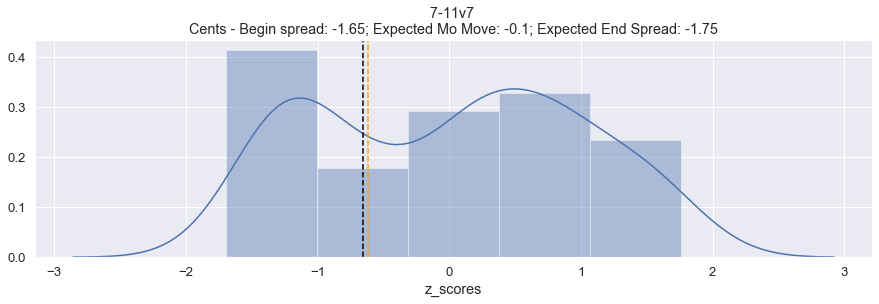

Begin spread z: -0.41 Expected End Spread z: -0.53


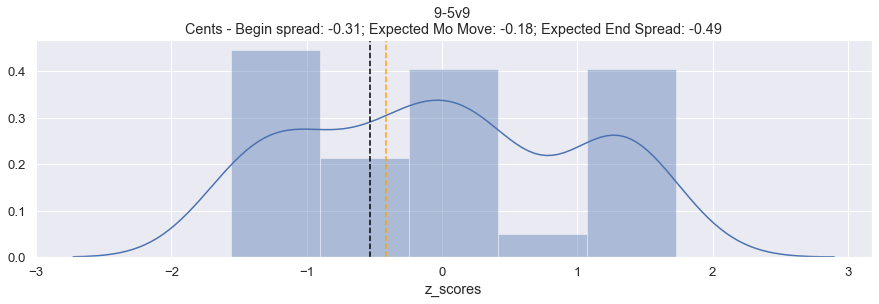

Begin spread z: -0.39 Expected End Spread z: -0.5


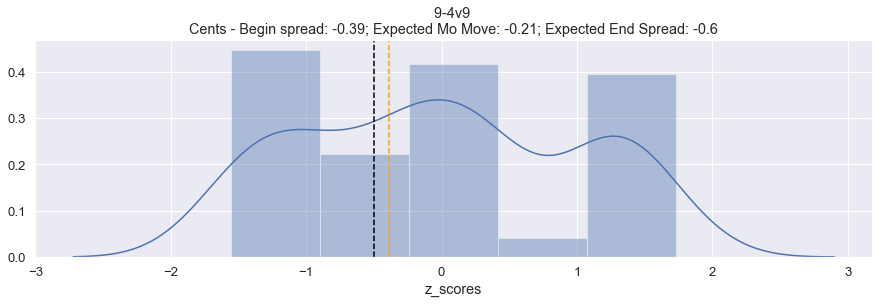

Begin spread z: -0.35 Expected End Spread z: -0.46


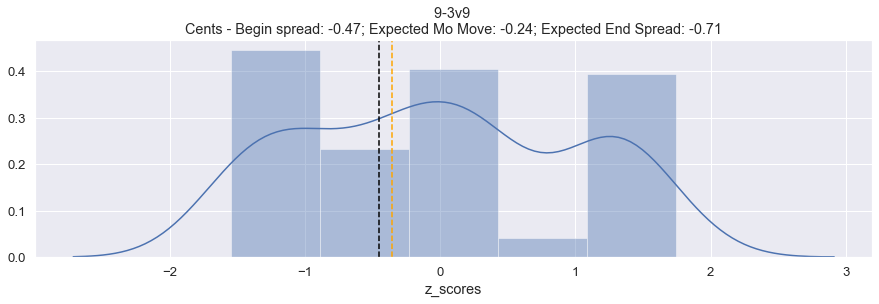

Begin spread z: -0.33 Expected End Spread z: -0.43


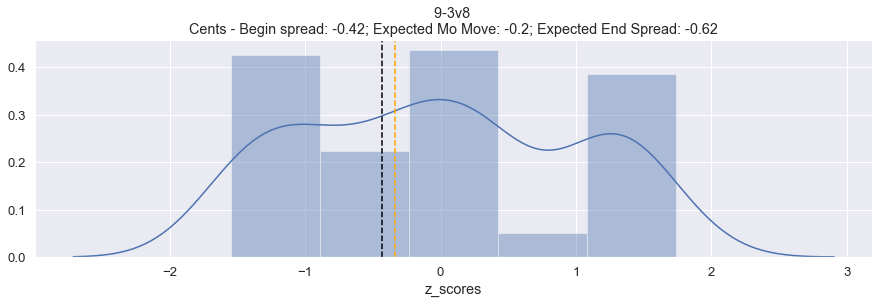

Begin spread z: -0.34 Expected End Spread z: -0.42


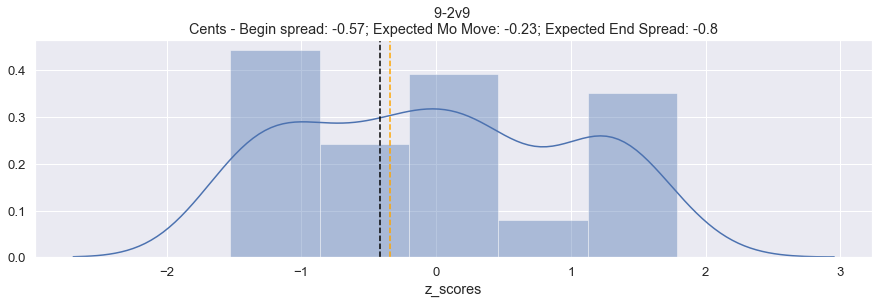

Begin spread z: 0.11 Expected End Spread z: -0.01


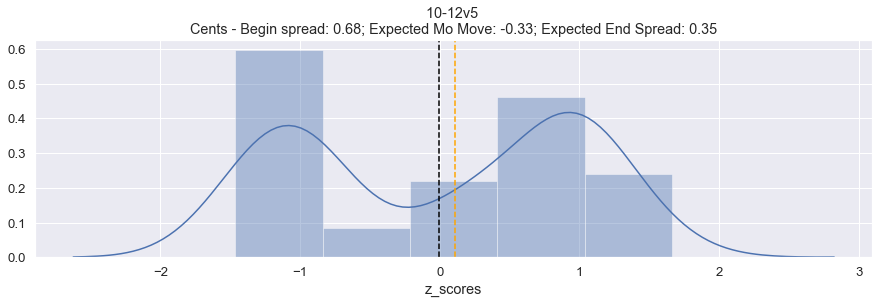

Begin spread z: 0.12 Expected End Spread z: 0.0


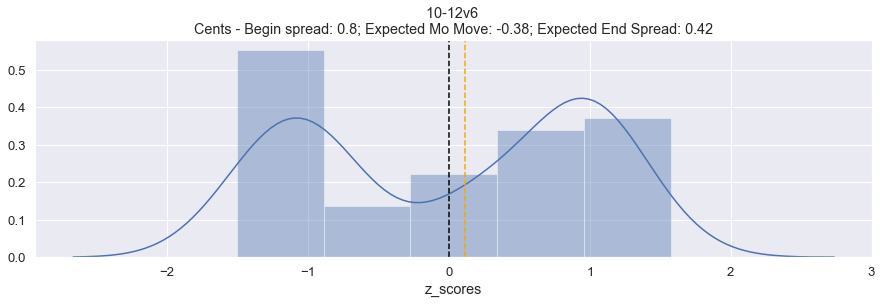

Begin spread z: 0.12 Expected End Spread z: 0.01


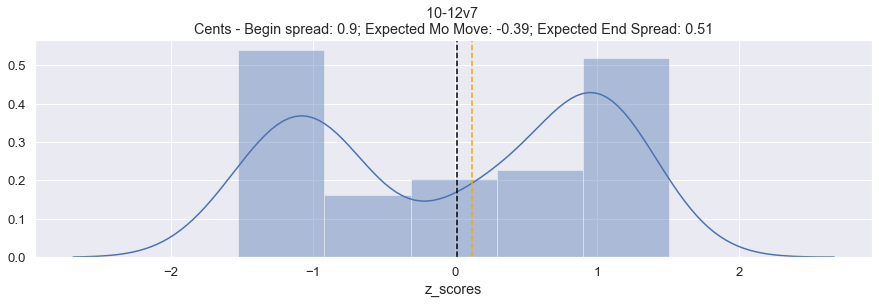

Begin spread z: 0.13 Expected End Spread z: 0.03


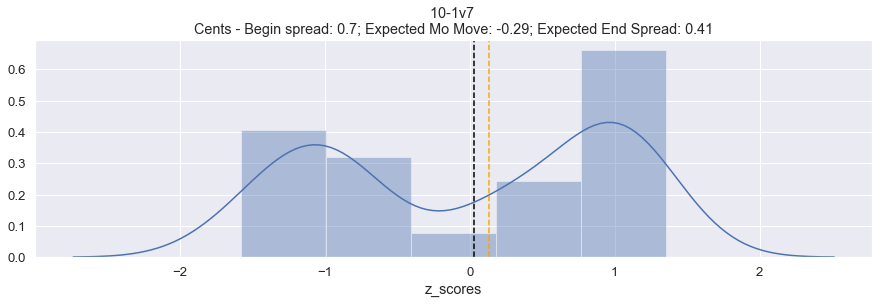

Begin spread z: 0.11 Expected End Spread z: 0.01


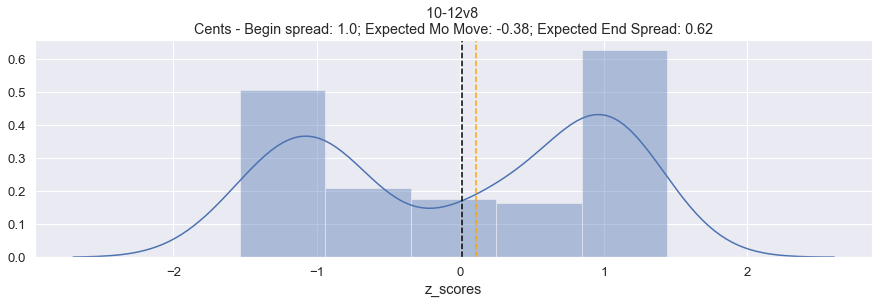

Begin spread z: 0.55 Expected End Spread z: 0.52


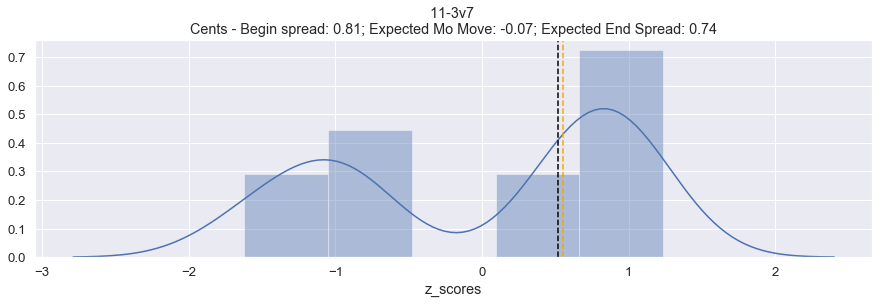

Begin spread z: 0.48 Expected End Spread z: 0.45


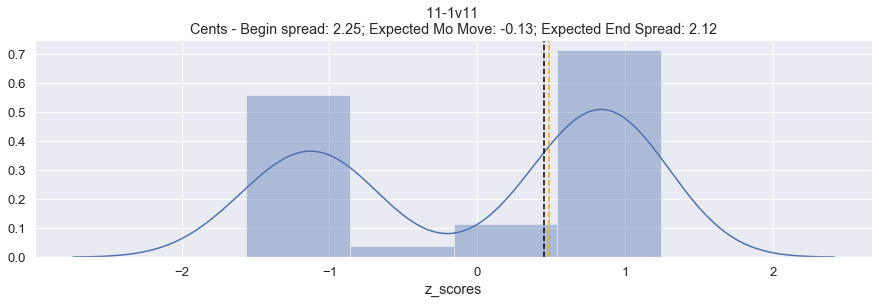

Begin spread z: 0.49 Expected End Spread z: 0.46


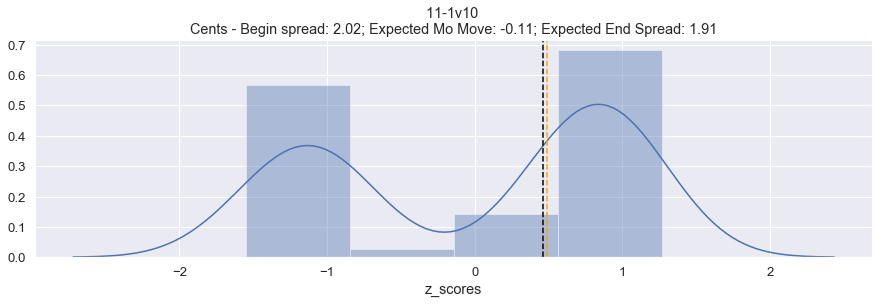

Begin spread z: 0.5 Expected End Spread z: 0.47


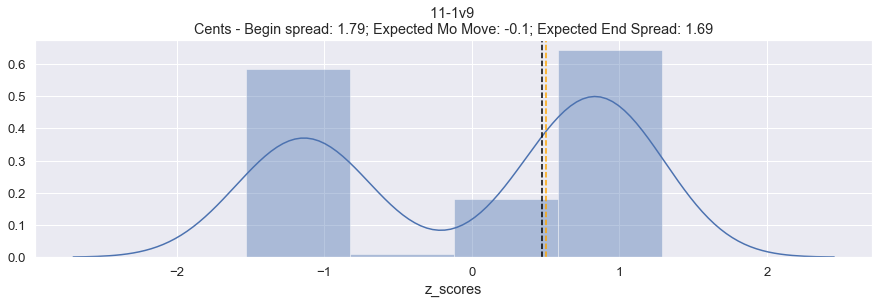

Begin spread z: 0.51 Expected End Spread z: 0.49


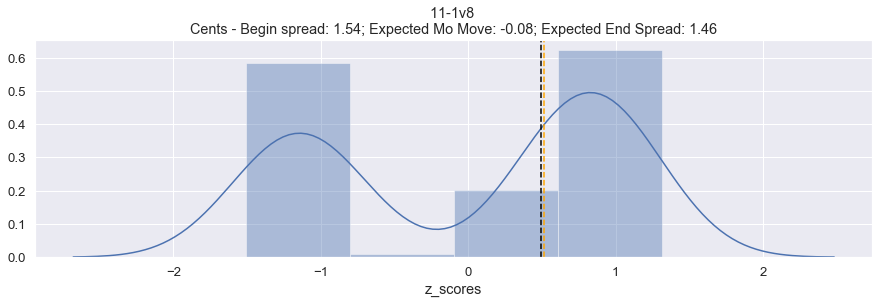

Begin spread z: 0.6 Expected End Spread z: 0.52


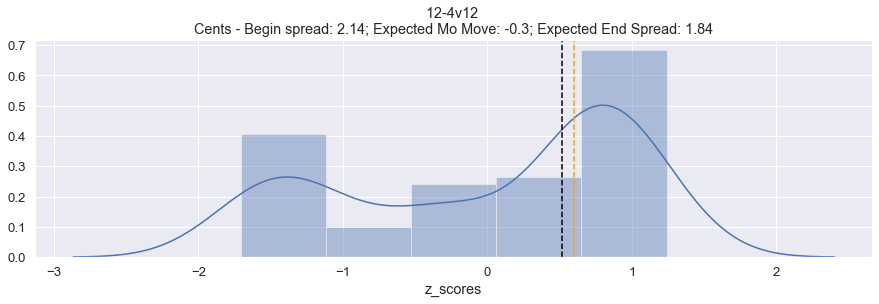

Begin spread z: 0.61 Expected End Spread z: 0.53


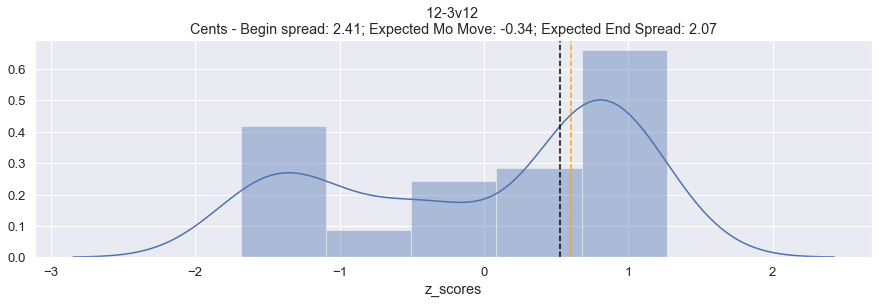

Begin spread z: 0.61 Expected End Spread z: 0.53


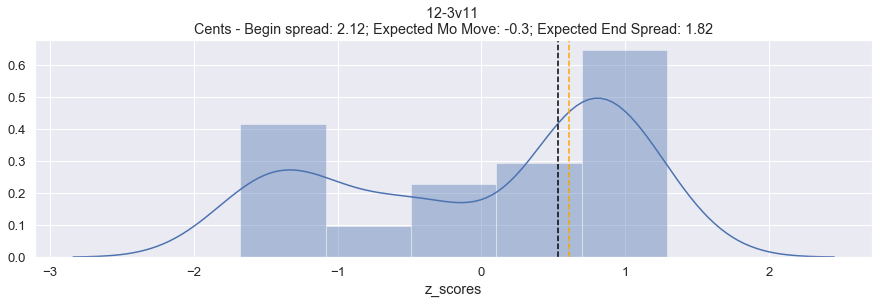

Begin spread z: 0.58 Expected End Spread z: 0.51


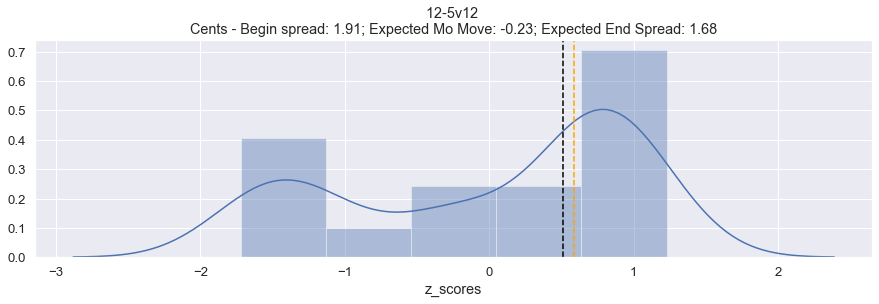

Begin spread z: 0.59 Expected End Spread z: 0.53


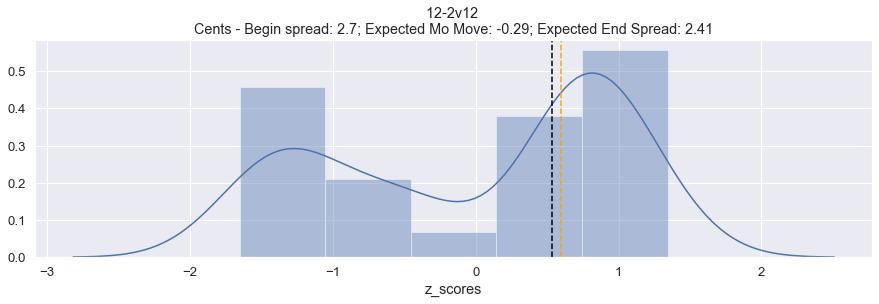

In [43]:
print('Best Bear Trades:\n')
for spread in dn_spreads:
    try:
        z_plot_spreads(df=tsFinal, z_column='spread', cml=spread)
    except:
        print(f'{spread} spread isn\'t available for month.\n')

In [44]:
write_table(trades_upF, f'trades_up_{startyr}_{endyr}')
write_table(trades_dnF, f'trades_dn_{startyr}_{endyr}')

### Portfolio Picker and P/L

In [45]:
#Pick bull -OR- bear trades for target calmonth.  If bulls are missing use bear and vice versa.
def pick_portfolio(calmonth):

    conn=sqlite3.connect('data.sqlite')  #instantiate connection
    trades_up_db=pd.read_sql(sql=f'SELECT mth, calmonth_spread_label, trade_up_sort FROM trades_up_{startyr}_{endyr}', con=conn)
    trades_dn_db=pd.read_sql(sql=f'SELECT mth, calmonth_spread_label, trade_dn_sort FROM trades_dn_{startyr}_{endyr}', con=conn)

    up_mth = trades_up_db[trades_up_db['mth'] == calmonth].copy()
    up_mth['plSign'] = 1
    up_avg_abs = abs(up_mth['trade_up_sort'].mean())

    dn_mth = trades_dn_db[trades_dn_db['mth'] == calmonth].copy()
    dn_mth['plSign'] = -1
    dn_avg_abs = abs(dn_mth['trade_dn_sort'].mean())

    #Pick bull or bear.  Return just the #1 trade.
    if up_avg_abs >= dn_avg_abs:
        return up_mth.iloc[[0]]
    elif up_avg_abs < dn_avg_abs:
        return dn_mth.iloc[[0]]
    elif np.isnan(up_avg_abs):
        return dn_mth.iloc[[0]]
    elif np.isnan(dn_avg_abs):
        return up_mth.iloc[[0]]
    else:
        print('Numerical comparison error.')

In [46]:
#Add plYear, expiry to top_trades
def add_expiry_plYear(top_trades, PLYear)
 

#  CODE OMITTED FROM EDUCATIONAL MODEL

In [47]:
#Get prices - spread prices for entire endyr and plYear.  endyear is needed for initial price.
spreads = get_tspread(firstyr=endyr, finalyr=plYear)
print(f'spreads has {len(spreads)} rows.')
spreads.head(2)

spreads has 34386 rows.


Date product  Cal Year  Cal Month  spread calmonth_spread_label
0 2017-01-02   BRENT      2017          1   -0.67                 1-3v4
1 2017-01-02   BRENT      2017          1   -1.22                 1-3v5

In [48]:
#plYear - Create schedule of initial biz days by month.
initial_days_plYear = get_init_day(plYear)
display('initial_days_plYear:', initial_days_plYear.head(3))

'initial_days_plYear:'

init_day
month           
1     2017-12-29
2     2018-01-31
3     2018-02-28

In [49]:
#Return daily cml/trade prices needed for the subsequent profit/loss calc.
#Due to complexity, beg_day_price is fetched with a different function.
def get_trade_daily_prices(cml, PLYear, calmonth, price_df = spreads, init_days = initial_days_plYear):
    
#  CODE OMITTED FROM EDUCATIONAL MODEL

In [50]:
#Expiry date offset function.  Product must have Expiry table.
def offset_expiry_date(top_tradesM, cmlabel, year, trade_calmonth, days_to_offset):
    
    if len(top_tradesM) == 1:  #get exp_date from top portfolio.  subtract offset days.
        return (top_tradesM.loc[top['calmonth_spread_label'] == cmlabel, 'exp_date'] - days_to_offset*pd.offsets.BDay()).values[0]
    
#     elif product in ['RB']:  #set biz month-end expiry UNLESS front contract is prompt.
#         front_contract=int(re.search("[-]([0-9]?[0-9])", cmlabel).group(1))        
#         if (front_contract - trade_calmonth) == 1:  #if prompt front contract, expiration is month-end. offset needed.
#             return (pd.date_range(datetime.datetime(year, trade_calmonth, 1), periods=1, freq='BM') - days_to_offset*pd.offsets.BDay()).values[0]
#         return (pd.date_range(datetime.datetime(year, trade_calmonth, 1), periods=1, freq='BM')).values[0]
    
    else:
        print('Expiry date offset function error.')

In [51]:
# #Get price list by trade

#  CODE OMITTED FROM EDUCATIONAL MODEL

In [52]:
#Convert price list to dataframe
def list_to_df(capital_list, list_len):    
    capdf=pd.DataFrame()
    move_colnames=[]
    for i in range(0,list_len,3):  #Increment in 3s
        cmlabel = capital_list[i]
        dates=capital_list[i+1]
        nums = capital_list[i+2]

        newdates=pd.DataFrame(data=dates, columns=['Date_'+cmlabel])
        newnums = pd.DataFrame(data=nums, columns=['Price_'+cmlabel])
        capdf = pd.concat([capdf, newdates, newnums], axis=1)
        capdf['PLmove_'+cmlabel] = capdf['Price_'+cmlabel].diff()  #sum of col diff is P/L
        move_colnames.append('PLmove_'+cmlabel)
    return capdf, move_colnames

In [53]:
def flatten_list_of_lists(list_of_lists):
    flat_list = []
    for sublist in move_colnames_FY:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [66]:
top

mth calmonth_spread_label  trade_dn_sort  plSign  plYear   exp_date
0   12               12-4v12      -0.126735      -1    2019 2019-02-28

In [54]:
capdf_FY = pd.DataFrame()
move_colnames_FY = []
for calmo in range(1,13):
    #Pick bull OR bear trades for target calmonth.  Add expiry and year.
    top = pick_portfolio(calmo)
    top = add_expiry_plYear(top_trades=top, PLYear=plYear)
    
    #Get trades price list
    try:
        priceList = get_trade_price_lists(top_trades=top, PLYear=plYear, price_df=spreads)
    except:  #if there's an error, skip to next calmo
        print('=> Prices unavailable - skipping calmonth.')
        continue
    
    #For calmo - Convert price list to df.  Also, return the PL column names.
    capdf, move_colnames = list_to_df(capital_list=priceList, list_len=len(priceList))
    
    #Add calmo to capdf_FY
    capdf_FY = pd.concat([capdf_FY, capdf], axis = 1)
    move_colnames_FY.append(move_colnames)

#Flatten PL column names
move_colnames_FY = flatten_list_of_lists(move_colnames_FY)

1-3v4 | expiry: 2018-01-26
-------------------------------
2-4v11 | expiry: 2018-02-23
-------------------------------
3-5v12 | expiry: 2018-03-26
-------------------------------
4-6v4 | expiry: 2018-04-25
-------------------------------
5-10v5 | expiry: 2018-08-28
-------------------------------
6-8v2 | expiry: 2018-06-26
-------------------------------
7-9v10 | expiry: 2018-07-26
-------------------------------
8-10v5 | expiry: 2018-08-28
-------------------------------
9-11v1 | expiry: 2018-09-25
-------------------------------
10-12v5 | expiry: 2018-10-26
-------------------------------
11-3v7 | expiry: 2019-01-28
-------------------------------
12-4v12 | expiry: 2019-02-25
-------------------------------


In [55]:
top

mth calmonth_spread_label  trade_dn_sort  plSign  plYear   exp_date
0   12               12-4v12      -0.126735      -1    2019 2019-02-28

In [69]:
PL

PLmove_1-3v4     -0.06
PLmove_2-4v11    -0.19
PLmove_3-5v12    -0.85
PLmove_4-6v4      1.00
PLmove_5-10v5     0.88
PLmove_6-8v2      0.38
PLmove_7-9v10    -0.95
PLmove_8-10v5     0.31
PLmove_9-11v1     0.58
PLmove_10-12v5    1.45
PLmove_11-3v7     0.69
PLmove_12-4v12    0.96
dtype: float64

In [57]:
#Compute P/L
print('Set fit window in the 4th cell (startyr and endyr).\n')
print('***********  Backtester Summary  ***********')
print('startyr:', startyr, '| endyr:', endyr, '| plYear:', plYear)

PL = capdf_FY[move_colnames_FY].sum()
display(PL.round(4).head(2))
print('Cumulative YTD PL:', PL.sum().round(4))

Set fit window in the 4th cell (startyr and endyr).

***********  Backtester Summary  ***********
startyr: 2011 | endyr: 2017 | plYear: 2018


PLmove_1-3v4    -0.06
PLmove_2-4v11   -0.19
dtype: float64

Cumulative YTD PL: 4.2


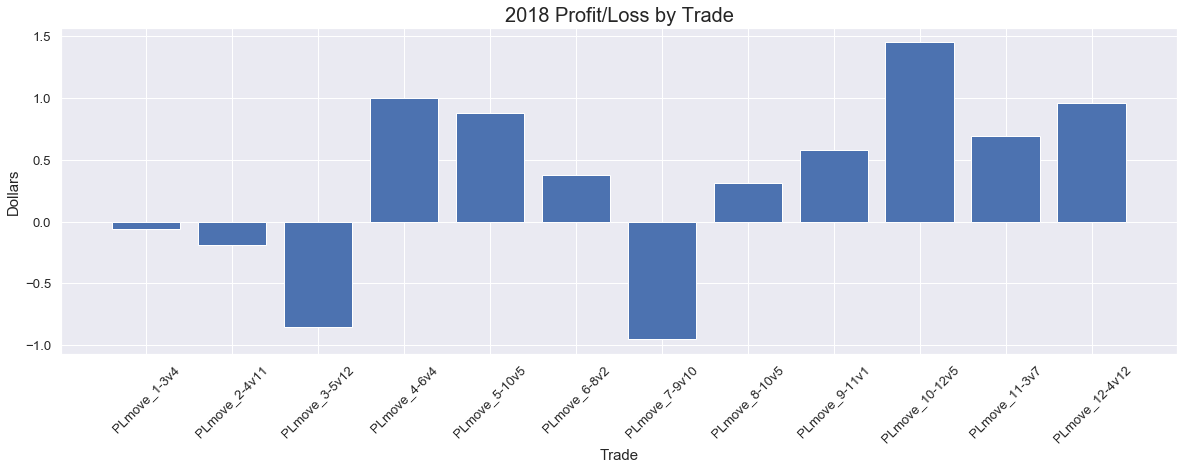

In [58]:
#Plot P/L
fig, ax = plt.subplots(figsize=(20,6))
ax.bar(x=PL.index, height=PL.values)
ax.set_title(f'{plYear} Profit/Loss by Trade', fontsize=20)
ax.set_xlabel('Trade', fontsize=15)
ax.set_ylabel('Dollars', fontsize=15)
ax.tick_params(axis = 'x', labelrotation =45)
plt.show()

Cumulative YTD PL: 4.2


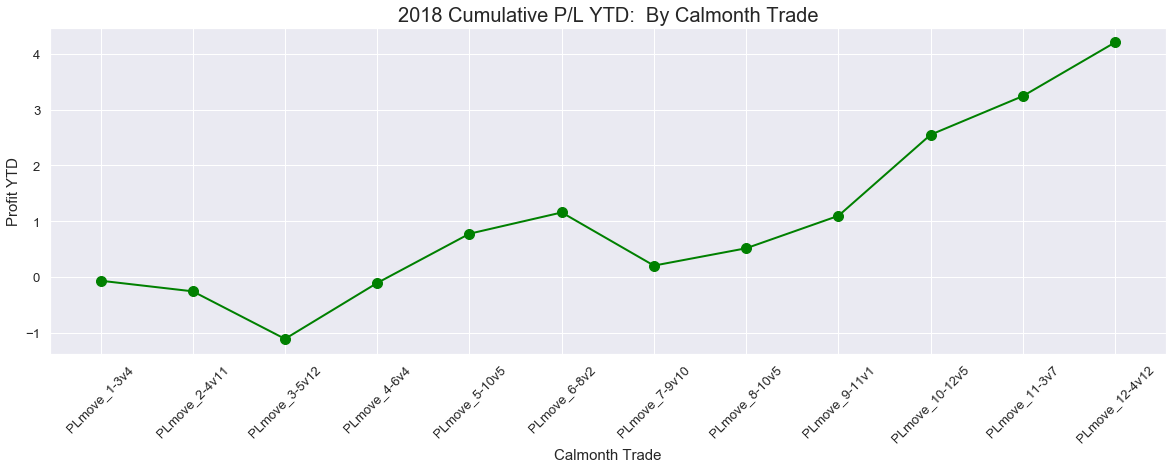

In [59]:
#Plot Cumulative P/L
print('Cumulative YTD PL:', PL.sum().round(4))
fig2, ax2 = plt.subplots(figsize=(20,6))
ax2.plot(move_colnames_FY, PL.cumsum(), color='green', marker='o', linewidth=2, markersize=10)
ax2.set_title(f'{plYear} Cumulative P/L YTD:  By Calmonth Trade', fontsize=20)
ax2.set_xlabel('Calmonth Trade', fontsize=15)
ax2.set_ylabel('Profit YTD', fontsize=15)
ax2.tick_params(axis = 'x', labelrotation = 45)
plt.show()

In [60]:
mend=time.time()
print('model runtime:', (mend-mstart)/60)

model runtime: 1.7400847752888997


In [61]:
#Beep when code is done.
from IPython.display import Audio
sound_file = 'https://www.soundjay.com/button/sounds/beep-07.mp3'
Audio(sound_file, autoplay=True)

In [62]:
PL

PLmove_1-3v4     -0.06
PLmove_2-4v11    -0.19
PLmove_3-5v12    -0.85
PLmove_4-6v4      1.00
PLmove_5-10v5     0.88
PLmove_6-8v2      0.38
PLmove_7-9v10    -0.95
PLmove_8-10v5     0.31
PLmove_9-11v1     0.58
PLmove_10-12v5    1.45
PLmove_11-3v7     0.69
PLmove_12-4v12    0.96
dtype: float64